# Notes
* RF CV duration: 0:45:27
* LGBM CV duration: 2:04:19 (to check without train monitoring)
* SVM CV duration: 2:07:10 + 1:51:49 + 2:25:45 + 2:12:35 + 2:08:47 + 2:12:35  + 2:02:3 = 15:00:44

# Setup

In [1]:
# Enable GPU for SVM (ThunderSVM)

# Install CUDA
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls  # Check if required cuda 9.0 amd64-deb file is downloaded
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls /var/cuda-repo-9-0-local | grep .pub
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!sudo apt-get install cuda-9.0
# Check CUDA
!nvcc --version
# Install ThunderSVM
!pip install thundersvm

--2021-01-21 04:52:14--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.0.24
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.0.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb?Y9J1cBPhwn6vh_V_YYb1wzc8UqDMmZuAsw-sW2HJ9oCD3jj5baR5zNsXlenzmCkxJFIjS3MtVO264Sf-P6o8voQ7DoCaySGLZ74Qq_kkdQP0SfYmO2aC0Szqu7MC6DD-C1hx4mwtFyy14JGk5122U0_79WdEKPN59D1RZ9bSRP1xtPvRK0i5xSj9upWGER4Xwtuydt_MZrH8AhZRhz-S [following]
--2021-01-21 04:52:14--  https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb?Y9J1cBPhwn6vh_V_YYb1wzc8UqDMmZuAsw-sW2HJ9oCD3jj5baR5zNsXlenzmCkxJFIjS3MtVO264Sf-P6o8voQ7DoCaySGLZ74Qq_kkdQP0SfYmO2aC

In [2]:
# Enable GPU for LGBM (need to fix it, lot of redundant operations and errors)

# Get source code and build and compile LightGBM with GPU
!git clone --recursive https://github.com/Microsoft/LightGBM
!cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

Cloning into 'LightGBM'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 20804 (delta 36), reused 40 (delta 24), pack-reused 20726
Receiving objects: 100% (20804/20804), 16.55 MiB | 29.11 MiB/s, done.
Resolving deltas: 100% (15165/15165), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728        
Receiving objects: 100% (21728/21728)

In [3]:
import numpy as np
import pandas as pd
import os
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import random

from thundersvm import SVC
from thundersvm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from collections import Counter

from google.colab import drive
from datetime import datetime

In [4]:
drive.mount('/content/drive')
root_path = 'drive/My Drive/KU/Robin_lab_project' 
os.chdir(root_path)

Mounted at /content/drive


In [5]:
# Set details for saving the plots
DIRECTORY = "Plots/new_implementation_1x_data/"
FILENAME = "rank_negFiltered_atleast2max_negRatio_1_v2"

# Data exploration

In [ ]:
# Load data 
profiles_all = pd.read_csv(f"Data/ML_input/profiles_{FILENAME}.csv")
metadata_all = pd.read_csv(f"Data/ML_input/metadata_{FILENAME}.csv")

X = profiles_all.drop("label", axis=1)
X = StandardScaler().fit_transform(X)
y = profiles_all["label"]

print(X.shape)
print(y.shape)

(121044, 1002)
(121044,)


### PCA


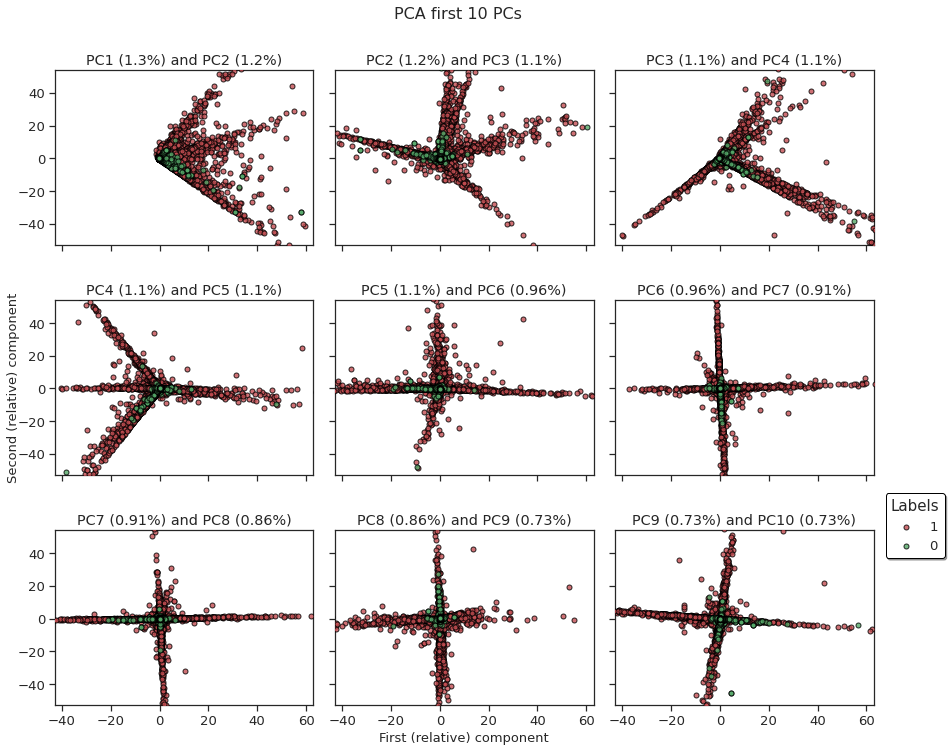

In [ ]:
#  PCA plot
def multi_plot_pca(x, y, 
                   nrows=2, xlim=(-23,43), ylim=(-23,23),
                   figsize=(12,7), top=0.89,
                   title="", save=False, filename="pca_multiplot"):
  # Perform PCA and MDS
  n_pcs = nrows*3+1
  pca = PCA(n_components=n_pcs)
  pcs = pca.fit_transform(x)
  var = pca.explained_variance_ratio_ * 100
  tmp_df = pd.concat([pd.DataFrame(pcs), y], axis = 1)
  targets = [1,0]
  colors = ["r","g"]
  # Plot fig and axes
  fig, axes = plt.subplots(nrows, 3, figsize = figsize, sharex=True, sharey=True)
  fig.add_subplot(111, frameon=False)
  for target, color in zip(targets,colors):
    i_keep = tmp_df['label'] == target
    for i ,ax in enumerate(axes.flatten()):
      ax.scatter(tmp_df.loc[i_keep,i], tmp_df.loc[i_keep,i+1], zorder=3, 
                      ec="black", c=color, s=25, alpha = 0.8, label = target) 
      ax.set_title(f"PC{i+1} ({var[i]:.2}%) and PC{i+2} ({var[i+1]:.2}%)")
      ax.set_xlim(xlim)
      ax.set_ylim(ylim)
  # Details
  legend = ax.legend(title="Labels", title_fontsize=15,
                     frameon = 1, shadow = True, bbox_to_anchor=(1.3, 1.25))
  frame = legend.get_frame()
  frame.set_facecolor('white')
  frame.set_edgecolor('black')
  plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
  fig.suptitle(f"PCA first {n_pcs} PCs{title}", fontsize=16)
  plt.xlabel("First (relative) component", fontsize=13)
  plt.ylabel("Second (relative) component", fontsize=13)
  fig.tight_layout()
  fig.subplots_adjust(top=top)
  if save == True:
      plt.savefig(f"{DIRECTORY}{filename}_{FILENAME}.png", dpi = 300)
  plt.show()

multi_plot_pca(X, y, nrows=3, xlim=(-43,63), ylim=(-53,54),
               figsize=(14,11), top=0.9, save=True)     

### Correlation

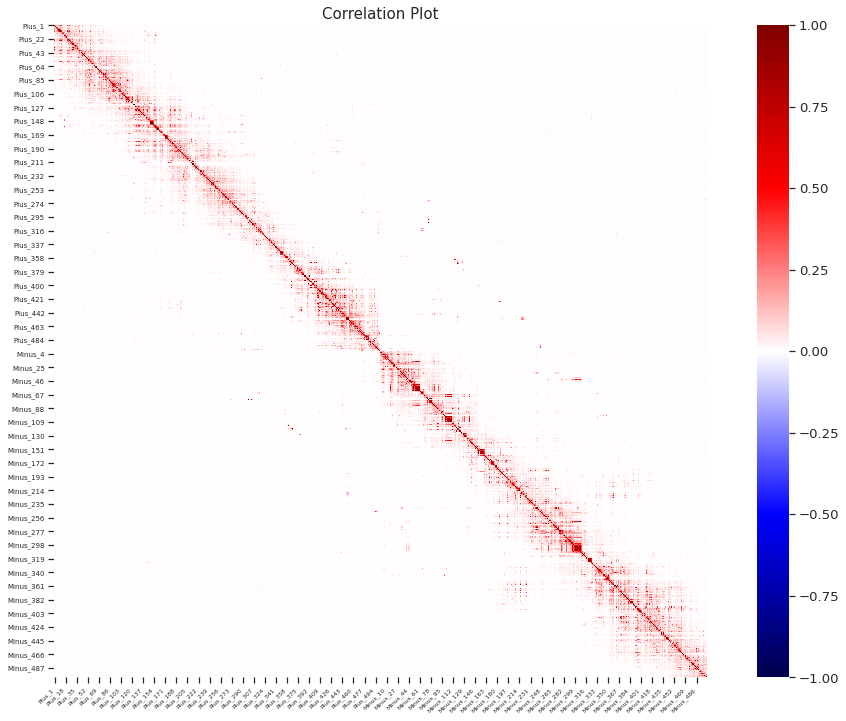

In [ ]:
# Correlation
X = pd.DataFrame(X, columns = list(profiles_all.drop("label", axis=1).columns))
correlation = X.corr(method='pearson')

# Plot
fig, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(correlation, mask = np.zeros_like(correlation, dtype = np.bool), cmap = "seismic",
            square=True, ax=ax, vmin=-1, vmax=1)
plt.title("Correlation Plot", fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.yticks(fontsize=7)
plt.savefig(f"{DIRECTORY}correlation_plot_{FILENAME}.png", dpi = 300)
plt.show()

# Models development

### Split train and test by chromosomes number

In [6]:
# Load data train & test splitted by chr
profiles_train = pd.read_csv(f"Data/ML_input/profiles_{FILENAME}_train.csv")
profiles_test = pd.read_csv(f"Data/ML_input/profiles_{FILENAME}_test.csv")
metadata_train = pd.read_csv(f"Data/ML_input/metadata_{FILENAME}_train.csv")
metadata_test = pd.read_csv(f"Data/ML_input/metadata_{FILENAME}_test.csv")

# Divide predictor and target
X_TRAIN = profiles_train.drop("label", axis = 1)
y_TRAIN = profiles_train["label"]
X_TEST = profiles_test.drop("label", axis = 1)
y_TEST = profiles_test["label"]

print(X_TRAIN.shape)
print(y_TRAIN.shape)
print(X_TEST.shape)
print(y_TEST.shape)

(99379, 1002)
(99379,)
(21665, 1002)
(21665,)


Some useful general functions

In [7]:
def get_accuracy(ypred, y):
  return sum(ypred == y) / len(y)

# def get_rmse(yprob, y):
#   return np.sqrt(np.mean((yprob-y)**2))

def get_tnr_tpr(ytrue, ypred):
  cf_matrix = confusion_matrix(ytrue, ypred)
  group_counts = [f"{value}" for value in cf_matrix.flatten()]
  row_sums = cf_matrix.sum(axis=1)
  norm_matrix = cf_matrix / row_sums[:, np.newaxis]
  group_percentages = [round(value, 2) for value in norm_matrix.flatten()]
  tnr, tpr = group_percentages[0], group_percentages[3]
  return tnr, tpr

def get_eval(ytrue, ypred):
  acc = get_accuracy(ypred, ytrue)
  f1 = f1_score(ytrue, ypred, average='macro')
  mcc = matthews_corrcoef(ytrue, ypred)
  tnr, tpr = get_tnr_tpr(ytrue, ypred)
  return acc, f1, mcc, tnr, tpr

def print_eval(ytrain, ytrain_pred, ytest, ytest_pred, is_test=False):
  train_acc, train_f1, train_mcc, _, _ = get_eval(ytrain, ytrain_pred)
  test_acc, test_f1, test_mcc, test_tnr, test_tpr = get_eval(ytest, ytest_pred)
  if is_test:  
    name = "Test"
  else:
    name = "Val"
  print(f"Train accuracy: {train_acc:.4}")
  print(f"Train F1-score: {train_f1:.4}")  
  print(f"Train MCC: {train_mcc:.4}")
  print(f"{name} accuracy: {test_acc:.4}")
  print(f"{name} F1-score: {test_f1:.4}")
  print(f"{name} MCC: {test_mcc:.4}")
  print(f"{name} TNR = {test_tnr*100:.2f}%")
  print(f"{name} TPR = {test_tpr*100:.2f}%")

def print_output_eval(train_output, test_output, is_test=False):
  print_eval(train_output["ytrue"].values, train_output["ypred"].values, 
             test_output["ytrue"].values, test_output["ypred"].values, is_test)

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}

def normalize(xtrain, xtest):
  scaler = StandardScaler()
  xtrain = pd.DataFrame(scaler.fit_transform(xtrain))
  xtest = pd.DataFrame(scaler.transform(xtest))
  return xtrain, xtest

def cv_split(metadata, n_val_chr=3, cv_seed=None):
  chr_list = np.unique(metadata.chr)
  random.seed(cv_seed)
  random.shuffle(chr_list)
  k = len(chr_list) // n_val_chr
  val_chr_folds = np.array_split(chr_list, k)
  return val_chr_folds

def store_cv_iter(train_yprob, train_ypred, train_ytrue,
                  val_yprob, val_ypred, val_ytrue, 
                  cv_iter, model="svm"):
  train_iter_output = pd.DataFrame({"yprob": train_yprob, "ypred": train_ypred, "ytrue": train_ytrue})
  val_iter_output = pd.DataFrame({"yprob": val_yprob, "ypred": val_ypred, "ytrue": val_ytrue})
  train_iter_output.to_csv(f"{DIRECTORY}{model}_cv_val_output_{cv_iter}_{FILENAME}.csv", index=False)
  val_iter_output.to_csv(f"{DIRECTORY}{model}_cv_train_output_{cv_iter}_{FILENAME}.csv", index=False)

def load_cv_iter(model="svm", max_cv_iter=7, print_shape=False):
  for cv_iter in range(1, max_cv_iter+1):
    train_name = f"{DIRECTORY}{model}_cv_train_output_{cv_iter}_{FILENAME}.csv"
    val_name = f"{DIRECTORY}{model}_cv_val_output_{cv_iter}_{FILENAME}.csv"
    if print_shape:
      print(f"CV {cv_iter} Train = {pd.read_csv(train_name).shape}")
      print(f"CV {cv_iter} Test  = {pd.read_csv(val_name).shape}")
    if cv_iter == 1:
      train_output = pd.read_csv(train_name)
      val_output = pd.read_csv(val_name)
    else:
      train_output = pd.concat((train_output, pd.read_csv(train_name)))
      val_output = pd.concat((val_output, pd.read_csv(val_name)))
  return train_output, val_output

Subset the data for fast testing

In [ ]:
# # Use reduced size TRAIN & TEST data
# metadata_train = metadata_train[:9000]
# metadata_test = metadata_test[:3000]
# X_TRAIN, y_TRAIN = X_TRAIN[:9000], y_TRAIN[:9000]
# X_TEST, y_TEST= X_TEST[:3000], y_TEST[:3000]

# print(metadata_train.shape)
# print(metadata_test.shape)
# print(X_TRAIN.shape, y_TRAIN.shape)
# print(X_TEST.shape, y_TEST.shape)

(9000, 3)
(3000, 3)
(9000, 1002) (9000,)
(3000, 1002) (3000,)


## Random forest

### Hyperparameter tuning

In [ ]:
# CV split by chr for par search
def search_cv_split(metadata, n_val_chr=6, max_cv_iter="auto", cv_seed=None):
  val_chr_folds = cv_split(metadata, n_val_chr, cv_seed)
  if max_cv_iter != "auto":
    val_chr_folds = val_chr_folds[0:max_cv_iter]
  print("Validation chromosomes:")
  [print(list(x)) for x in val_chr_folds]
  # Generate a list of tuple where each tuple contain two list of indexes (train and val)
  list_fold_index = []
  for val_chr in val_chr_folds:
    ival = metadata.chr.isin(val_chr)
    list_fold_index.append((list(np.where(~ival)[0]), list(np.where(ival)[0])))
  return list_fold_index

# Hyperparameters random or grid search
def par_search(model, param_grid,
               xtrain, ytrain, metadata, 
               search="random", n_iter=24, n_val_chr=6, max_cv_iter="auto", 
               cv_seed=None, verbose=10):
  if search == "random":
    print(f"Hyperparameters search = {search}\n")
    model_search = RandomizedSearchCV(estimator = model, param_distributions = param_grid, n_iter = n_iter, 
                                      return_train_score = True, 
                                      cv = search_cv_split(metadata, n_val_chr, max_cv_iter, cv_seed), 
                                      scoring = make_scorer(f1_score, average = "macro"), verbose=verbose)
  elif search == "grid":
    print(f"Hyperparameters search = {search}\n")
    model_search = GridSearchCV(estimator = model, param_grid = param_grid, return_train_score = True,
                                cv = search_cv_split(metadata, n_val_chr, max_cv_iter, cv_seed), 
                                scoring = make_scorer(f1_score, average = "macro"), verbose=verbose)
  try:
    print("\nParameter grid:")
    display(param_grid)
    print("")
    model_search.fit(xtrain, ytrain)
    return model_search
  except:
    print("Search argument must be \"random\" or \"grid\"")

Comment out the following for parameter tuning

In [ ]:
# # Perform search
# bootstrap = [True, False]
# criterion = ['gini']
# n_estimators = [10, 20, 100, 500, 1000]
# max_features = ["auto"]
# max_depth = [104, None]
# min_samples_split = [2, 5, 10, 0.1]
# min_samples_leaf = [1, 2, 4, 0.1]
# max_leaf_nodes = [None]

# param_grid = { 
#     "bootstrap": bootstrap,
#     "criterion" : criterion,
#     "n_estimators": n_estimators,
#     "max_features": max_features,
#     "max_depth" : max_depth,
#     "min_samples_split": min_samples_split,
#     "min_samples_leaf": min_samples_leaf,
#     "max_leaf_nodes": max_leaf_nodes
# }

# Suggested by Marco

param_grid = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 5, 10, 20],
              'min_samples_split': [2, 5, 10, 20],
              'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

rf_clf = RandomForestClassifier(n_jobs=-1, class_weight = "balanced_subsample")

rf_search_output = par_search(rf_clf, param_grid,
                              X_TRAIN, y_TRAIN, metadata_train, 
                              search="random", n_iter=150, 
                              n_val_chr=10, max_cv_iter="auto", 
                              cv_seed=33, verbose=5)

# # Potrei usare un subset of 16k samples per velocizzare oppure utilizzare una normale CV per splittare in train and test 
# # (cosi da poter fare due iterazioni ma mantenere 70% test 30% train)

# # Plot parameters
# # Make a function that take a df of predictors and plot each one against a target variable vector
# # Ha senso solo per grid search 
# # Se il parameter è categorical, fai box_plot, se numerical plotta una linea

In [ ]:
def get_search_combination(search_output):
  result_search = pd.DataFrame(search_output.cv_results_)
  drop_col1 = ['std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'std_test_score', 'std_train_score']
  drop_col2 = result_search.columns[result_search.columns.str.startswith('split')]
  drop_col = drop_col1 + list(drop_col2)
#   result_search = result_search.drop(drop_col, axis = 1).sort_values("rank_test_score")
  # Convert NA value to None
  if "param_max_depth" in rf_par_combination.columns:
    rf_par_combination.loc[rf_par_combination.loc[:,"param_max_depth"].isnull(),"param_max_depth"] = None
  return result_search

rf_par_combination = get_search_combination(rf_search_output)
display(rf_par_combination.head(20))

rf_par_combination.to_csv(f"{DIRECTORY}rf_opt_parameters_{FILENAME}.csv", index=False)

In [ ]:
# Load optimal parameters
rf_par_combination = pd.read_csv(f"{DIRECTORY}rf_opt_parameters_{FILENAME}.csv")

In [ ]:
# Assign optimal parameters
rf_opt_par = rf_par_combination.iloc[:,rf_par_combination.columns.str.startswith('param')].head(1)
display(rf_opt_par)

[param_n_estimators, param_min_samples_split,	param_min_samples_leaf,	
 param_max_features,	param_max_depth,	param_bootstrap] = list(rf_opt_par.values[0])

### Training and validation

In [ ]:
def rf_pred(model, x):
  y_prob = model.predict_proba(x)[:,1]
  y_pred = model.predict(x)
  return y_prob, y_pred

def rf_train_pred(xtrain, ytrain, xval, yval, class_weight=None,
                  n_estimators=100, bootstrap=True, criterion="gini", 
                  max_depth=None, max_features="auto", max_leaf_nodes=None,
                  min_samples_leaf=1, min_samples_split=2, 
                  train_only=False, name="RF"):
  start_time = datetime.now()
  # Train
  model = RandomForestClassifier(n_estimators=n_estimators, bootstrap=bootstrap, 
                                 criterion=criterion, max_depth=max_depth, 
                                 max_features=max_features, class_weight=class_weight,
                                 random_state=49)
  model.fit(xtrain, ytrain)
  # Predict
  if train_only:
    return model
  else:
    ytrain_prob, ytrain_pred = rf_pred(model, xtrain)
    yval_prob, yval_pred = rf_pred(model, xval)
    # Evaluate
    print_eval(ytrain, ytrain_pred, yval, yval_pred, name)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return model, ytrain_prob, ytrain_pred, yval_prob, yval_pred

In [ ]:
# Random forest CV
def rf_cv(xtrain, ytrain, metadata, n_val_chr=3, cv_seed=None, 
          normalization=False, class_weight=None, name="RF",
          n_estimators=100, bootstrap="True", criterion="gini", 
          max_depth=None, max_features="auto", max_leaf_nodes=None,
          min_samples_leaf=1, min_samples_split=2):
  start_time = datetime.now()
  print(f"Performing {name} CV")
  # Initialize arrays to store predictions, true values and feat importance
  train_yprob_vec, train_ypred_vec, train_ytrue_vec = np.array([]), np.array([]), np.array([])
  val_yprob_vec, val_ypred_vec, val_ytrue_vec = np.array([]), np.array([]), np.array([])
  importance = pd.DataFrame()
  importance["feature"] = list(xtrain.columns)
  # Compute class weights if requested
  if class_weight == "custom":
    class_weight = get_class_weights(ytrain.values)
  print(f"Class weigths = {class_weight}")  
  # CV by chromosomes
  val_chr_folds = cv_split(metadata, n_val_chr, cv_seed)
  for i, val_chr in enumerate(val_chr_folds):
    print(f"\n> Starting CV iteration {i+1}, valid chrs = {', '.join(str(i) for i in val_chr)}") 
    ival = metadata.chr.isin(val_chr)
    X_train, X_val = xtrain[~ival], xtrain[ival]
    y_train, y_val = ytrain[~ival], ytrain[ival]
    # Normalization
    if normalization:
      X_train, X_val = normalize(X_train, X_val)
    # Train and predict
    [model, train_yprob, train_ypred, 
     val_yprob, val_ypred] = rf_train_pred(X_train, y_train, X_val, y_val, 
                                           n_estimators=n_estimators, 
                                           bootstrap=bootstrap, 
                                           criterion=criterion, 
                                           max_depth=max_depth, 
                                           max_features=max_features, 
                                           max_leaf_nodes=max_leaf_nodes,
                                           min_samples_leaf=min_samples_leaf, 
                                           min_samples_split=min_samples_split,
                                           class_weight=class_weight)
    importance[f"iteration_{i+1}"] = model.feature_importances_
    # Store prediction on training data
    train_yprob_vec = np.concatenate((train_yprob_vec, train_yprob))
    train_ypred_vec = np.concatenate((train_ypred_vec, train_ypred))
    train_ytrue_vec = np.concatenate((train_ytrue_vec, y_train))
    # Store prediction on validation data
    val_yprob_vec = np.concatenate((val_yprob_vec, val_yprob))
    val_ypred_vec = np.concatenate((val_ypred_vec, val_ypred))
    val_ytrue_vec = np.concatenate((val_ytrue_vec, y_val))
  # Stack training and validation predictions into two panda df
  train_output = pd.DataFrame({"yprob": train_yprob_vec, "ypred": train_ypred_vec, "ytrue": train_ytrue_vec})
  val_output = pd.DataFrame({"yprob": val_yprob_vec, "ypred": val_ypred_vec, "ytrue": val_ytrue_vec})
  importance["average"] = np.mean(importance, 1)
  # Evaluate
  print(f"\n>> {name} CV final report")
  print_output_eval(train_output, val_output)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return train_output, val_output, importance

In [ ]:
# Run RF CV
rf_cv_train_output, rf_cv_val_output, rf_importance = rf_cv(X_TRAIN, y_TRAIN, metadata_train, cv_seed=33)

Performing RF CV
Class weigths = None

> Starting CV iteration 1, valid chrs = chr13, chr12, chr10
Train accuracy: 0.9584
Train F1-score: 0.9583
Train MCC: 0.9194
Test accuracy: 0.7393
Test F1-score: 0.7391
Test MCC: 0.4799
Test TNR = 77.00%
Test TPR = 71.00%
Duration: 0:06:35.571882

> Starting CV iteration 2, valid chrs = chr15, chr1, chr20
Train accuracy: 0.9586
Train F1-score: 0.9586
Train MCC: 0.9199
Test accuracy: 0.7194
Test F1-score: 0.7194
Test MCC: 0.4402
Test TNR = 74.00%
Test TPR = 70.00%
Duration: 0:06:11.515340

> Starting CV iteration 3, valid chrs = chr11, chr22, chrY
Train accuracy: 0.957
Train F1-score: 0.957
Train MCC: 0.9169
Test accuracy: 0.7111
Test F1-score: 0.7111
Test MCC: 0.4229
Test TNR = 70.00%
Test TPR = 73.00%
Duration: 0:06:50.074800

> Starting CV iteration 4, valid chrs = chr21, chr5, chr7
Train accuracy: 0.9585
Train F1-score: 0.9585
Train MCC: 0.9196
Test accuracy: 0.7475
Test F1-score: 0.7467
Test MCC: 0.4952
Test TNR = 79.00%
Test TPR = 71.00%
Durat

In [ ]:
# Store prediction
rf_cv_train_output.to_csv(f"{DIRECTORY}rf_cv_train_output_{FILENAME}.csv", index=False)
rf_cv_val_output.to_csv(f"{DIRECTORY}rf_cv_val_output_{FILENAME}.csv", index=False)

Comment out the following for optimized parameters validation

In [ ]:
# rf_opt_train_output, rf_opt_val_output, rf_opt_importance = rf_cv(X_TRAIN, y_TRAIN, metadata_train, 
#                                                                   class_weigth="custom",
#                                                                   name="RF tuned balanced",
#                                                                   n_estimators=param_n_estimators, 
#                                                                   bootstrap=param_bootstrap,       
#                                                                   max_depth=param_max_depth, 
#                                                                   max_features=param_max_features,
#                                                                   min_samples_leaf=param_min_samples_leaf,
#                                                                   min_samples_split=param_min_samples_split)

### Testing

In [ ]:
# RF prediction on test data
def rf_test_pred(xtrain, ytrain, xtest, ytest, 
                 train_only=True, class_weight=None, name="RF",
                 n_estimators=100, bootstrap="True", criterion="gini", 
                 max_depth=None, max_features="auto", max_leaf_nodes=None,
                 min_samples_leaf=1, min_samples_split=2):
  start_time = datetime.now()
  print(f">> {name} train on full TRAIN data and pred on TEST data")
  importance = pd.DataFrame()
  importance["feature"] = list(xtrain.columns)
  # Compute class weights if requested
  if class_weight == "custom":
    class_weight = get_class_weights(ytrain.values)
  print(f"Class weigths = {class_weight}")  
  # CV by chromosomes
  # Train
  model = rf_train_pred(xtrain, ytrain, xtest, ytest, train_only=True,
                        n_estimators=n_estimators, 
                        bootstrap=bootstrap, 
                        criterion=criterion, 
                        max_depth=max_depth, 
                        max_features=max_features, 
                        max_leaf_nodes=max_leaf_nodes,
                        min_samples_leaf=min_samples_leaf, 
                        min_samples_split=min_samples_split,
                        class_weight=class_weight)
  importance["average"] = model.feature_importances_
  # Predict
  ytrain_prob, ytrain_pred = rf_pred(model, xtrain)
  ytest_prob, ytest_pred = rf_pred(model, xtest)
  train_output = pd.DataFrame({"yprob": ytrain_prob, "ypred": ytrain_pred, "ytrue": ytrain})
  test_output = pd.DataFrame({"yprob": ytest_prob, "ypred": ytest_pred, "ytrue": ytest})
  # # Evaluate
  print_output_eval(train_output, test_output, is_test=True)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return model, train_output, test_output, importance

rf_model, rf_train_output, rf_test_output , _ = rf_test_pred(X_TRAIN, y_TRAIN, X_TEST, y_TEST)

>> RF train on full TRAIN data and pred on TEST data
Class weigths = None


In [ ]:
# Store prediction
rf_train_output.to_csv(f"{DIRECTORY}rf_train_output_{FILENAME}.csv", index=False)
rf_test_output.to_csv(f"{DIRECTORY}rf_test_output_{FILENAME}.csv", index=False)

## LightGBM    

In [8]:
# Scoring functions
def lgb_mcc_score(y_pred, y_true):
    y_true = y_true.get_label()
    y_pred = np.round(y_pred)
    is_higher_better = True
    return 'MCC', matthews_corrcoef(y_true, y_pred), is_higher_better

def lgb_f1_score(y_pred, y_true):
    y_true = y_true.get_label()
    y_pred = np.round(y_pred)
    is_higher_better = True
    return 'F1', f1_score(y_true, y_pred, average='macro'), is_higher_better

def tnr_tpr_score(y_true, y_pred):
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_counts = [f"{value}" for value in cf_matrix.flatten()]
    row_sums = cf_matrix.sum(axis=1)
    norm_matrix = cf_matrix / row_sums[:, np.newaxis]
    return norm_matrix.flatten()[0], norm_matrix.flatten()[3]

def lgb_tnr_score(y_pred, y_true):
    y_true = y_true.get_label()
    y_pred = np.round(y_pred)
    is_higher_better = True
    return 'TNR', tnr_tpr_score(y_true, y_pred)[0], is_higher_better

def lgb_tpr_score(y_pred, y_true):
    y_true = y_true.get_label()
    y_pred = np.round(y_pred)
    is_higher_better = True
    return 'TPR', tnr_tpr_score(y_true, y_pred)[1], is_higher_better
    
# Plot metrics during training
def lgb_plot_eval_result(evals_result, best_iteration, num_iterations, 
                     val_chr=None, name="LGBM"):
  plt.figure(figsize=(12, 8))
  gs = gridspec.GridSpec(2, 2)
  subplot_indexes = (0,0), (0,1), (1,0), (1,1)
  names = list(evals_result["val"].keys())
  for i, indexes in enumerate(subplot_indexes):
    if i < 3:
      # Plot all metrics except TNR and TPR
      ax = plt.subplot(gs[indexes])
      lgb.plot_metric(evals_result, metric=names[i], ax=ax)  
      ax.set_title(names[i].replace("_", " "), fontsize = 12)  
    else:
      # Plot TNR and TPR
      ax = plt.subplot(gs[1, 1])
      ax.plot(evals_result["val"]["TNR"], label="Val TNR", color="tab:orange")
      ax.plot(evals_result["val"]["TPR"], label="Val TPR", color="tab:red")
      ax.plot(evals_result["train"]["TNR"], label="Train TNR", color="tab:cyan")
      ax.plot(evals_result["train"]["TPR"], label="Train TPR", color="tab:blue")
      plt.grid(zorder=0) 
      ax.set_title("TNR and TPR", fontsize = 12)
      ax.set_ylabel("TR", fontsize = 10)
      ax.set_xlabel("Iterations", fontsize = 10)
    # Add early stopping iteration and legend
    if num_iterations > best_iteration and best_iteration != 0:
      ax.vlines(best_iteration, ymin=-1, ymax=1, color="r", linestyles="dashed", linewidth=0.8, label="best_iter") 
    legend = ax.legend(frameon = 1, shadow = True)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black') 
  # Set title and save
  title = "Training progression"
  if val_chr is not None:
    val_chr_str = f"{', '.join(str(i) for i in val_chr)}"
    title += f" ({name}, val on {val_chr_str})"
  else:
    title += f" ({name}, eval on test data)"
  plt.suptitle(title, size=14, y=1.035)
  plt.tight_layout()
  plt.savefig(f"{DIRECTORY}{title}.png", dpi = 300, bbox_inches='tight')
  plt.show()

# Other LGBM functions
def lgb_class_weigths(ytrain, class_weight, par):
  if class_weigth == "custom":  
    class_weight = get_class_weights(ytrain.values)
    pos_weight = round(class_weight[1] / class_weigth[0], 2)
    par["scale_pos_weight"] = pos_weight
  elif class_weigth == "balanced":
    par["is_unbalance "] = True
  return par

def lgb_print_par(par, num_iterations, early_stopping_rounds):
  print("\nParameters:")
  print(f"  num_iterations = {num_iterations}")
  print(f"  early_stopping_rounds = {early_stopping_rounds}")
  [print(f"  {x} = {par[x]}") for x in par]

In [9]:
# Perform training and prediction
def lgb_pred(model, x):
  y_prob = model.predict(np.array(x))
  y_pred = np.round(y_prob)
  return y_prob, y_pred
  
def lgb_train_pred(xtrain, ytrain, xtest, ytest, par, 
                   num_iterations=1500, early_stopping_rounds=None, 
                   plot_eval=False, val_chr=None, name="LGBM"):
  start_time = datetime.now()
  # Train
  train_data = lgb.Dataset(xtrain , label = ytrain, 
                           free_raw_data = False)
  valid_data = lgb.Dataset(xtest, label = ytest,
                           free_raw_data = False)
  evals_result = {}
  if plot_eval:
    model = lgb.train(par, train_data, valid_sets=[train_data, valid_data], valid_names=["train", "val"], 
                      feval = lambda y_pred, y_true: [lgb_mcc_score(y_pred, y_true), lgb_f1_score(y_pred, y_true),
                                                      lgb_tnr_score(y_pred, y_true), lgb_tpr_score(y_pred, y_true)], 
                      verbose_eval=50, evals_result=evals_result, num_boost_round=num_iterations, 
                      early_stopping_rounds=early_stopping_rounds)
  else:
    model = lgb.train(par, train_data, valid_sets=[valid_data], valid_names=["val"], 
                      verbose_eval=50, num_boost_round=num_iterations, 
                      early_stopping_rounds=early_stopping_rounds)
  # Predict
  ytrain_prob, ytrain_pred = lgb_pred(model, xtrain)
  ytest_prob, ytest_pred = lgb_pred(model, xtest)
  # Evaluate
  print("")
  print_eval(ytrain, ytrain_pred, ytest, ytest_pred)
  if plot_eval:
    lgb_plot_eval_result(evals_result, model.best_iteration, num_iterations, val_chr, name)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return model, ytrain_prob, ytrain_pred, ytest_prob, ytest_pred

In [10]:
# LGBM CV
def lgb_cv(xtrain, ytrain, metadata, par, 
           num_iterations=1500, early_stopping_rounds=None,
           n_val_chr=3, cv_seed=None, normalization=True, 
           class_weight=None, plot_eval=False, name="LGBM"):
  start_time = datetime.now()
  print(f"Performing {name} CV")
  # Initialize 1d df to store predictions and true values
  train_yprob_vec, train_ypred_vec, train_ytrue_vec = np.array([]), np.array([]), np.array([])
  val_yprob_vec, val_ypred_vec, val_ytrue_vec = np.array([]), np.array([]), np.array([])
  importance = pd.DataFrame()
  importance["feature"] = list(xtrain.columns)
  # Set class weigth
  if class_weight is not None:
    par = lgb_class_weigths(ytrain, class_weight, par)
  # Print parameters
  lgb_print_par(par, num_iterations, early_stopping_rounds)
  # CV by chromosomes
  val_chr_folds = cv_split(metadata, n_val_chr, cv_seed)
  for i, val_chr in enumerate(val_chr_folds):
    print(f"\n> Starting CV iteration {i+1}, valid chrs = {', '.join(str(i) for i in val_chr)}") 
    ival = metadata.chr.isin(val_chr)
    X_train, X_val = xtrain[~ival], xtrain[ival]
    y_train, y_val = ytrain[~ival], ytrain[ival]
    # Normalization
    if normalization:
      X_train, X_val = normalize(X_train, X_val)
    # Train and predict
    model, train_yprob, train_ypred, val_yprob, val_ypred = lgb_train_pred(X_train, y_train, X_val, y_val, par=par,
                                                                           num_iterations=num_iterations,
                                                                           early_stopping_rounds=early_stopping_rounds,
                                                                           plot_eval=plot_eval, val_chr=val_chr, name=name)
    importance[f"iteration_{i+1}"] = model.feature_importance(importance_type='gain')
    # Store prediction on training data
    train_yprob_vec = np.concatenate((train_yprob_vec, train_yprob))
    train_ypred_vec = np.concatenate((train_ypred_vec, train_ypred))
    train_ytrue_vec = np.concatenate((train_ytrue_vec, y_train))
    # Store prediction on validation data
    val_yprob_vec = np.concatenate((val_yprob_vec, val_yprob))
    val_ypred_vec = np.concatenate((val_ypred_vec, val_ypred))
    val_ytrue_vec = np.concatenate((val_ytrue_vec, y_val))
  # Stack training and validation predictions into two panda df
  train_output = pd.DataFrame({"yprob": train_yprob_vec, "ypred": train_ypred_vec,"ytrue": train_ytrue_vec})
  val_output = pd.DataFrame({"yprob": val_yprob_vec, "ypred": val_ypred_vec,"ytrue": val_ytrue_vec})
  importance["average"] = np.mean(importance, 1)
  # Evaluate
  print(f"\n>> {name} CV final report")
  print_output_eval(train_output, val_output)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return train_output, val_output, importance

# Fixed parameters
learning_rate = 0.009

In [15]:
# LGBM with class weights (without monitoring the training process with different metrics)
params = {"application" : "binary",
          "metric" : "binary_logloss",
          "force_row_wise" : True,
          "learning_rate" : learning_rate,
          "scale_pos_weight": 1.65,
          'device': 'gpu',
          'gpu_platform_id': 0,
          'gpu_device_id': 0         
}
lgb_cv_train_output, lgb_cv_val_output, lgb_importance = lgb_cv(X_TRAIN, y_TRAIN, metadata_train, params, 
                                                         num_iterations=1500, cv_seed=33, plot_eval=False,
                                                         name="LGBM (Val CV)")

Performing LGBM (Val CV) CV

Parameters:
  num_iterations = 1500
  early_stopping_rounds = None
  application = binary
  metric = binary_logloss
  force_row_wise = True
  learning_rate = 0.009
  scale_pos_weight = 1.65
  device = gpu
  gpu_platform_id = 0
  gpu_device_id = 0

> Starting CV iteration 1, valid chrs = chr13, chr12, chr10
[LightGBM] [Info] Number of positive: 42862, number of negative: 42171
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 75045
[LightGBM] [Info] Number of data points in the train set: 85033, number of used features: 1002
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504063 -> initscore=0.016253

Performing LGBM (Val CV) CV

Parameters:
  num_iterations = 1500
  early_stopping_rounds = None
  application = binary
  metric = binary_logloss
  force_row_wise = True
  learning_rate = 0.009

> Starting CV iteration 1, valid chrs = chr13, chr12, chr10


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.627324	train's MCC: 0.478923	train's F1: 0.726534	train's TNR: 0.86007	train's TPR: 0.603285	val's binary_logloss: 0.629562	val's MCC: 0.475195	val's F1: 0.720235	val's TNR: 0.876313	val's TPR: 0.577494
[100]	train's binary_logloss: 0.589014	train's MCC: 0.487468	train's F1: 0.729958	train's TNR: 0.867468	train's TPR: 0.603192	val's binary_logloss: 0.59216	val's MCC: 0.482425	val's F1: 0.722077	val's TNR: 0.885558	val's TPR: 0.573054
[150]	train's binary_logloss: 0.564999	train's MCC: 0.491717	train's F1: 0.731681	train's TNR: 0.871001	train's TPR: 0.603308	val's binary_logloss: 0.568595	val's MCC: 0.487994	val's F1: 0.724574	val's TNR: 0.88892	val's TPR: 0.574719
[200]	train's binary_logloss: 0.54917	train's MCC: 0.494143	train's F1: 0.732703	train's TNR: 0.872851	train's TPR: 0.603588	val's binary_logloss: 0.553403	val's MCC: 0.489338	val's F1: 0.724779	val's TNR: 0.891021	val's TPR: 0.573331
[250]	train's binary_logloss: 0.538176	train's MCC: 0.495767	

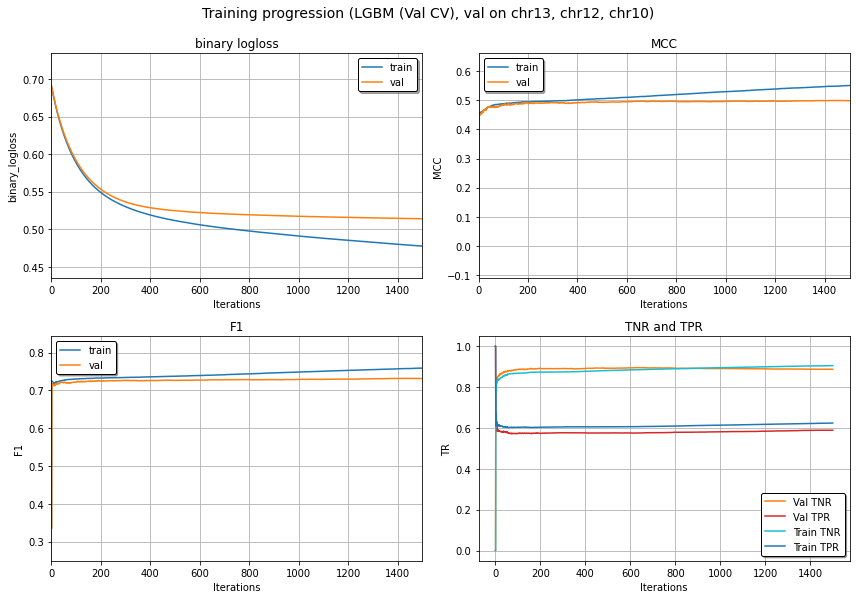

Duration: 0:27:57.489102

> Starting CV iteration 2, valid chrs = chr15, chr1, chr20
[50]	train's binary_logloss: 0.625925	train's MCC: 0.484306	train's F1: 0.728161	train's TNR: 0.868132	train's TPR: 0.598284	val's binary_logloss: 0.632048	val's MCC: 0.444971	val's F1: 0.705017	val's TNR: 0.857797	val's TPR: 0.570686
[100]	train's binary_logloss: 0.586672	train's MCC: 0.493634	train's F1: 0.732125	train's TNR: 0.875046	train's TPR: 0.59957	val's binary_logloss: 0.597025	val's MCC: 0.454198	val's F1: 0.709095	val's TNR: 0.863936	val's TPR: 0.572973
[150]	train's binary_logloss: 0.562075	train's MCC: 0.498973	train's F1: 0.734411	train's TNR: 0.878888	train's TPR: 0.600435	val's binary_logloss: 0.575947	val's MCC: 0.460361	val's F1: 0.71233	val's TNR: 0.866168	val's TPR: 0.576923
[200]	train's binary_logloss: 0.54588	train's MCC: 0.501558	train's F1: 0.735935	train's TNR: 0.879136	train's TPR: 0.603006	val's binary_logloss: 0.562848	val's MCC: 0.461201	val's F1: 0.712855	val's TNR: 0.86

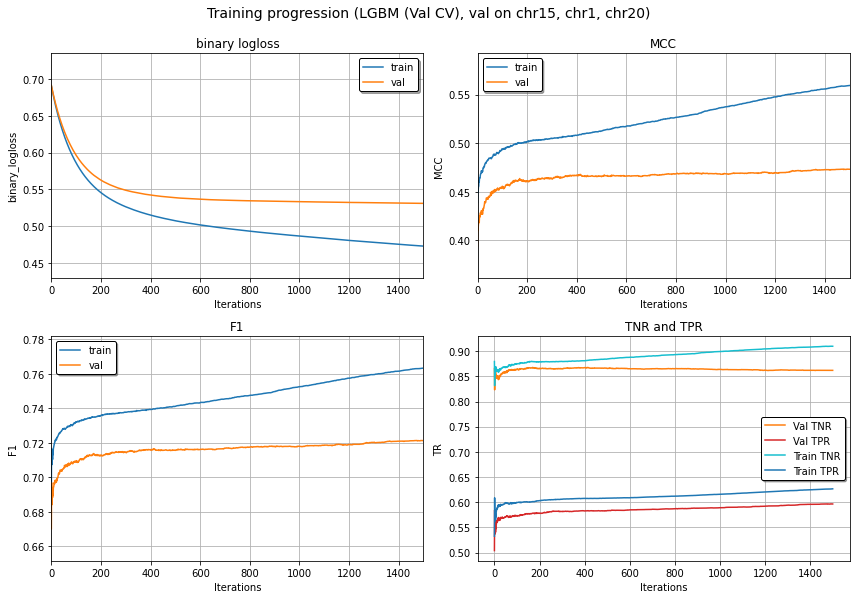

Duration: 0:27:45.597618

> Starting CV iteration 3, valid chrs = chr11, chr22, chrY


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.626589	train's MCC: 0.480011	train's F1: 0.72813	train's TNR: 0.85541	train's TPR: 0.610637	val's binary_logloss: 0.631941	val's MCC: 0.43421	val's F1: 0.710536	val's TNR: 0.813869	val's TPR: 0.610416
[100]	train's binary_logloss: 0.587665	train's MCC: 0.490101	train's F1: 0.731712	train's TNR: 0.86635	train's TPR: 0.607786	val's binary_logloss: 0.597355	val's MCC: 0.447141	val's F1: 0.71632	val's TNR: 0.823867	val's TPR: 0.612204
[150]	train's binary_logloss: 0.563231	train's MCC: 0.497108	train's F1: 0.734222	train's TNR: 0.873568	train's TPR: 0.606185	val's binary_logloss: 0.576907	val's MCC: 0.449088	val's F1: 0.716717	val's TNR: 0.828122	val's TPR: 0.609075
[200]	train's binary_logloss: 0.547168	train's MCC: 0.499815	train's F1: 0.735487	train's TNR: 0.875137	train's TPR: 0.60715	val's binary_logloss: 0.564292	val's MCC: 0.455419	val's F1: 0.720001	val's TNR: 0.830249	val's TPR: 0.613321
[250]	train's binary_logloss: 0.53608	train's MCC: 0.501514	tra

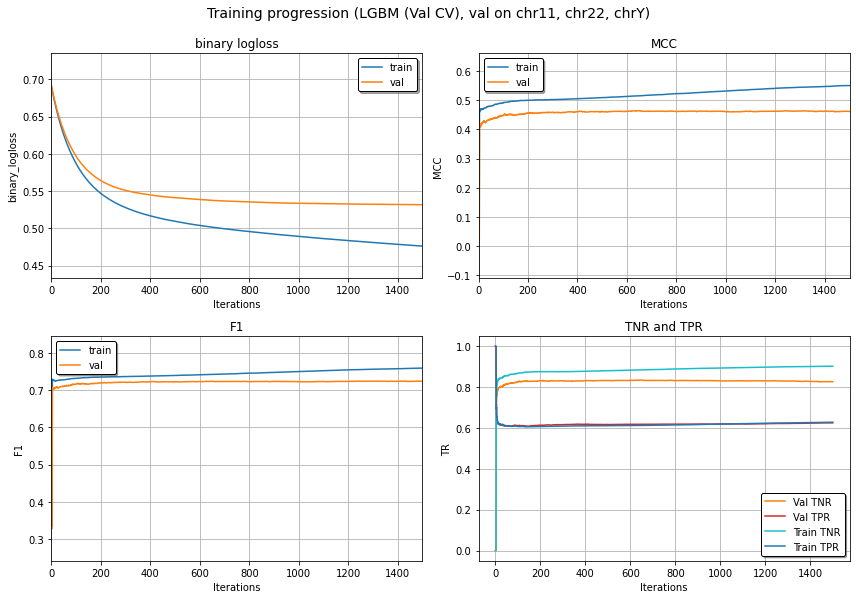

Duration: 0:28:33.271145

> Starting CV iteration 4, valid chrs = chr21, chr5, chr7


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.627195	train's MCC: 0.475645	train's F1: 0.725669	train's TNR: 0.854447	train's TPR: 0.607132	val's binary_logloss: 0.630632	val's MCC: 0.471164	val's F1: 0.718844	val's TNR: 0.876734	val's TPR: 0.570416
[100]	train's binary_logloss: 0.588811	train's MCC: 0.48548	train's F1: 0.729751	train's TNR: 0.862562	train's TPR: 0.607639	val's binary_logloss: 0.593417	val's MCC: 0.485969	val's F1: 0.724918	val's TNR: 0.887572	val's TPR: 0.572075
[150]	train's binary_logloss: 0.564789	train's MCC: 0.489704	train's F1: 0.731263	train's TNR: 0.866997	train's TPR: 0.606603	val's binary_logloss: 0.569909	val's MCC: 0.49327	val's F1: 0.726889	val's TNR: 0.896098	val's TPR: 0.568305
[200]	train's binary_logloss: 0.548984	train's MCC: 0.492822	train's F1: 0.732683	train's TNR: 0.868979	train's TPR: 0.607501	val's binary_logloss: 0.554759	val's MCC: 0.497333	val's F1: 0.728258	val's TNR: 0.899855	val's TPR: 0.567551
[250]	train's binary_logloss: 0.538035	train's MCC: 0.49434

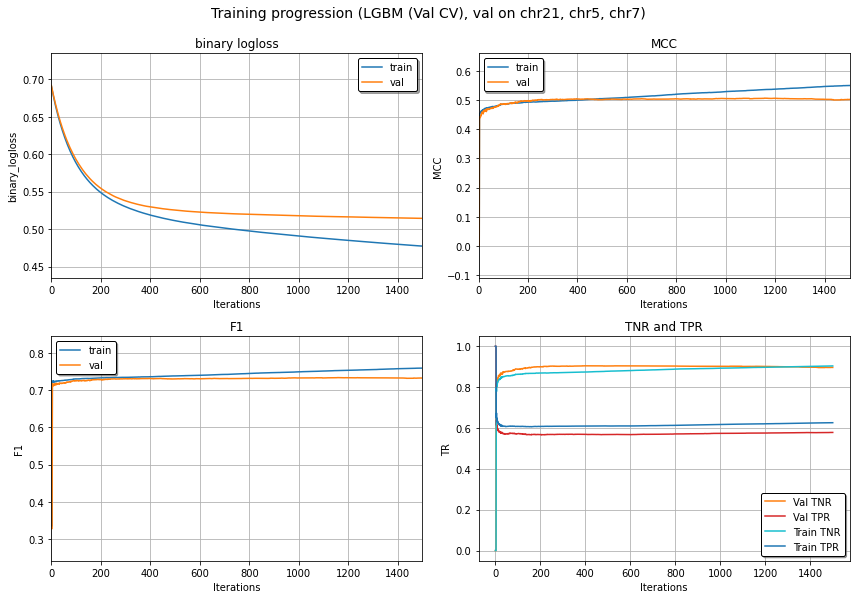

Duration: 0:28:04.587237

> Starting CV iteration 5, valid chrs = chr8, chr18, chr19


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.626687	train's MCC: 0.481535	train's F1: 0.727621	train's TNR: 0.862326	train's TPR: 0.603209	val's binary_logloss: 0.629468	val's MCC: 0.445433	val's F1: 0.715427	val's TNR: 0.815661	val's TPR: 0.621714
[100]	train's binary_logloss: 0.587896	train's MCC: 0.494464	train's F1: 0.732568	train's TNR: 0.874304	train's TPR: 0.601964	val's binary_logloss: 0.592974	val's MCC: 0.458824	val's F1: 0.721001	val's TNR: 0.828458	val's TPR: 0.620818
[150]	train's binary_logloss: 0.563572	train's MCC: 0.498239	train's F1: 0.734233	train's TNR: 0.876854	train's TPR: 0.602817	val's binary_logloss: 0.570759	val's MCC: 0.464822	val's F1: 0.724086	val's TNR: 0.830743	val's TPR: 0.624552
[200]	train's binary_logloss: 0.547618	train's MCC: 0.501065	train's F1: 0.735493	train's TNR: 0.878702	train's TPR: 0.603532	val's binary_logloss: 0.556961	val's MCC: 0.469602	val's F1: 0.726217	val's TNR: 0.8344	val's TPR: 0.625299
[250]	train's binary_logloss: 0.536566	train's MCC: 0.50213

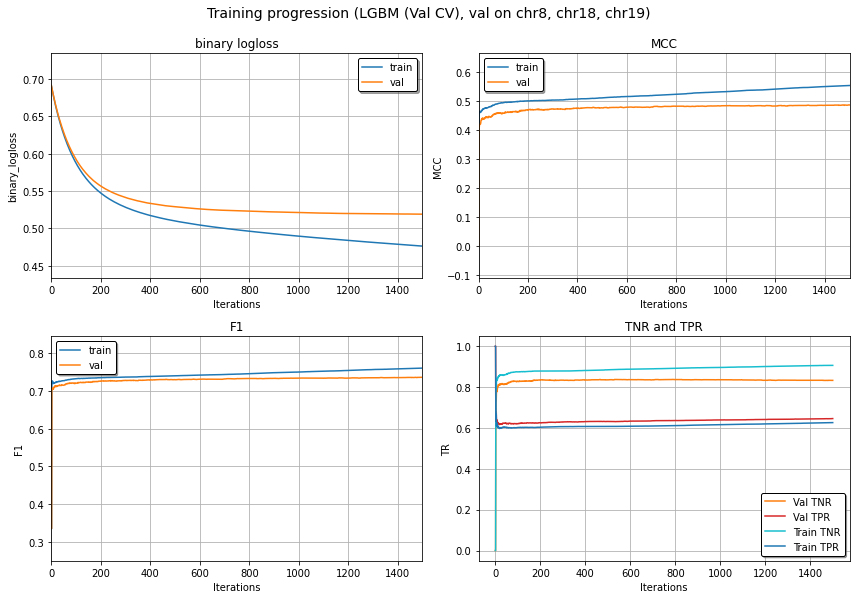

Duration: 0:28:06.218824

> Starting CV iteration 6, valid chrs = chrX, chr6, chr17


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.626998	train's MCC: 0.47728	train's F1: 0.725033	train's TNR: 0.863076	train's TPR: 0.597228	val's binary_logloss: 0.628791	val's MCC: 0.4613	val's F1: 0.718305	val's TNR: 0.845488	val's TPR: 0.6038
[100]	train's binary_logloss: 0.588528	train's MCC: 0.486996	train's F1: 0.728314	train's TNR: 0.873678	train's TPR: 0.594119	val's binary_logloss: 0.591392	val's MCC: 0.480095	val's F1: 0.726497	val's TNR: 0.859456	val's TPR: 0.606947
[150]	train's binary_logloss: 0.564457	train's MCC: 0.49231	train's F1: 0.73097	train's TNR: 0.876031	train's TPR: 0.596939	val's binary_logloss: 0.568411	val's MCC: 0.484051	val's F1: 0.728438	val's TNR: 0.861434	val's TPR: 0.608812
[200]	train's binary_logloss: 0.548592	train's MCC: 0.494195	train's F1: 0.732154	train's TNR: 0.875934	train's TPR: 0.599181	val's binary_logloss: 0.553742	val's MCC: 0.486056	val's F1: 0.729571	val's TNR: 0.861805	val's TPR: 0.610561
[250]	train's binary_logloss: 0.537554	train's MCC: 0.496155	tra

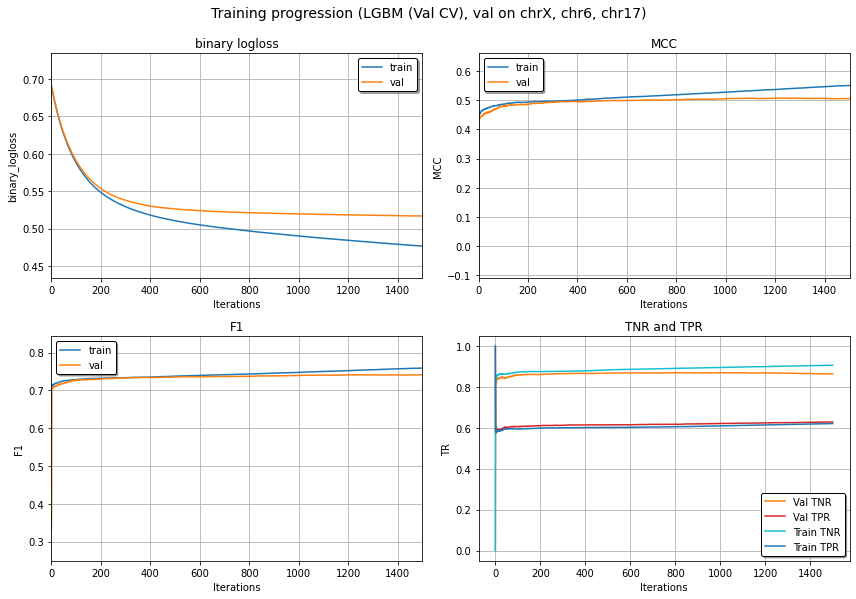

Duration: 0:27:50.192257

> Starting CV iteration 7, valid chrs = chr16, chr14, chr9


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.62708	train's MCC: 0.480762	train's F1: 0.727799	train's TNR: 0.859108	train's TPR: 0.60667	val's binary_logloss: 0.629116	val's MCC: 0.458885	val's F1: 0.720441	val's TNR: 0.834943	val's TPR: 0.612156
[100]	train's binary_logloss: 0.588496	train's MCC: 0.491971	train's F1: 0.731603	train's TNR: 0.871664	train's TPR: 0.602851	val's binary_logloss: 0.5921	val's MCC: 0.467075	val's F1: 0.722931	val's TNR: 0.846764	val's TPR: 0.606326
[150]	train's binary_logloss: 0.564278	train's MCC: 0.495822	train's F1: 0.733213	train's TNR: 0.874637	train's TPR: 0.603245	val's binary_logloss: 0.569256	val's MCC: 0.470534	val's F1: 0.724381	val's TNR: 0.849647	val's TPR: 0.606471
[200]	train's binary_logloss: 0.548352	train's MCC: 0.498894	train's F1: 0.734671	train's TNR: 0.876313	train's TPR: 0.604471	val's binary_logloss: 0.554768	val's MCC: 0.471205	val's F1: 0.724535	val's TNR: 0.8508	val's TPR: 0.605743
[250]	train's binary_logloss: 0.537267	train's MCC: 0.4998	trai

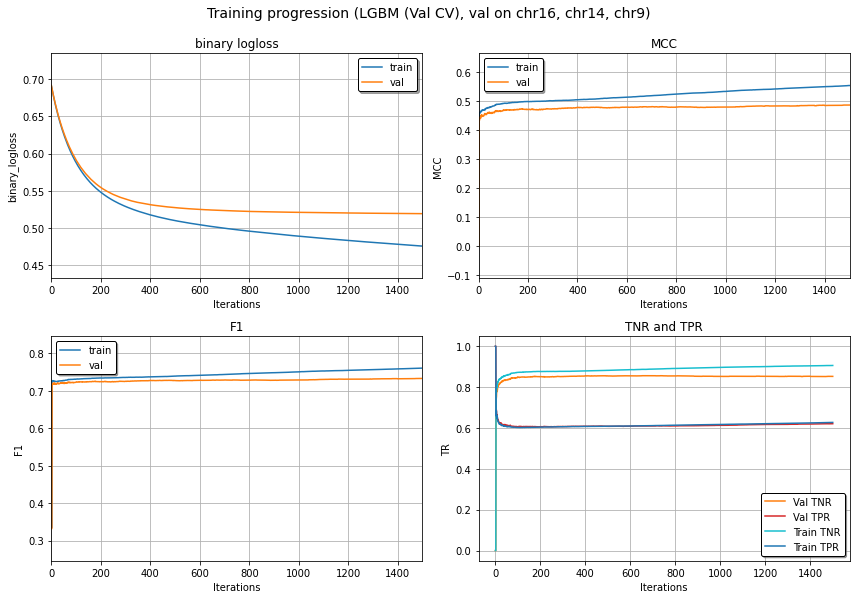

Duration: 0:28:19.306333

>> LGBM (Val CV) CV final report
Train accuracy: 0.7645
Train F1-score: 0.7602
Train MCC: 0.5526
Val accuracy: 0.7357
Val F1-score: 0.7318
Val MCC: 0.4884
Val TNR = 86.00%
Val TPR = 61.00%
Duration: 3:17:03.788591


In [ ]:
# LGBM no class weights
params = {"application" : "binary",
          "metric" : "binary_logloss",
          "force_row_wise" : True,
          "learning_rate" : learning_rate,
          "scale_pos_weight": 1.65,
          'device': 'gpu',
          'gpu_platform_id': 0,
          'gpu_device_id': 0         
}
lgb_cv_train_output, lgb_cv_val_output, lgb_importance = lgb_cv(X_TRAIN, y_TRAIN, metadata_train, params, 
                                                         num_iterations=1500, cv_seed=33, plot_eval=True,
                                                         name="LGBM (Val CV)")

Performing LGBM 1.65 (Val CV) CV

Parameters:
  num_iterations = 1500
  early_stopping_rounds = None
  application = binary
  metric = binary_logloss
  force_row_wise = True
  learning_rate = 0.009
  scale_pos_weight = 1.65
  device = gpu
  gpu_platform_id = 0
  gpu_device_id = 0

> Starting CV iteration 1, valid chrs = chr13, chr12, chr10
[LightGBM] [Info] Number of positive: 42862, number of negative: 42171
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 75045
[LightGBM] [Info] Number of data points in the train set: 85033, number of used features: 1002
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504063 -> initscore=0.0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.637182	train's MCC: 0.453001	train's F1: 0.724375	train's TNR: 0.668825	train's TPR: 0.781135	val's binary_logloss: 0.638924	val's MCC: 0.457199	val's F1: 0.727486	val's TNR: 0.687491	val's TPR: 0.768142
[100]	train's binary_logloss: 0.60494	train's MCC: 0.458006	train's F1: 0.72678	train's TNR: 0.670152	train's TPR: 0.784658	val's binary_logloss: 0.606879	val's MCC: 0.461047	val's F1: 0.729346	val's TNR: 0.688332	val's TPR: 0.771056
[150]	train's binary_logloss: 0.584478	train's MCC: 0.466299	train's F1: 0.731504	train's TNR: 0.682483	train's TPR: 0.781368	val's binary_logloss: 0.585875	val's MCC: 0.47297	val's F1: 0.735861	val's TNR: 0.705701	val's TPR: 0.766338
[200]	train's binary_logloss: 0.570676	train's MCC: 0.470388	train's F1: 0.733977	train's TNR: 0.691494	train's TPR: 0.777029	val's binary_logloss: 0.571514	val's MCC: 0.481559	val's F1: 0.740453	val's TNR: 0.718308	val's TPR: 0.762731
[250]	train's binary_logloss: 0.560848	train's MCC: 0.475511

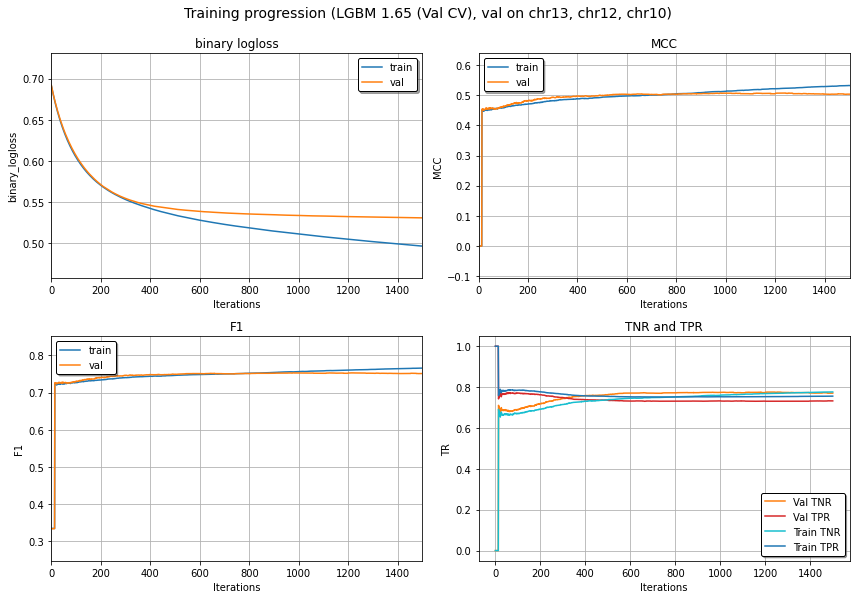

Duration: 0:16:56.455874

> Starting CV iteration 2, valid chrs = chr15, chr1, chr20
[LightGBM] [Info] Number of positive: 40449, number of negative: 40351
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 71561
[LightGBM] [Info] Number of data points in the train set: 80800, number of used features: 1002
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500606 -> initscore=0.002426
[LightGBM] [Info] Start training from score 0.002426


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.635843	train's MCC: 0.46608	train's F1: 0.732353	train's TNR: 0.701668	train's TPR: 0.763505	val's binary_logloss: 0.638686	val's MCC: 0.429942	val's F1: 0.714809	val's TNR: 0.689474	val's TPR: 0.739813
[100]	train's binary_logloss: 0.602693	train's MCC: 0.471847	train's F1: 0.734829	train's TNR: 0.696364	train's TPR: 0.774036	val's binary_logloss: 0.607815	val's MCC: 0.43604	val's F1: 0.717623	val's TNR: 0.683893	val's TPR: 0.750936
[150]	train's binary_logloss: 0.581522	train's MCC: 0.47709	train's F1: 0.737737	train's TNR: 0.704642	train's TPR: 0.771366	val's binary_logloss: 0.588746	val's MCC: 0.442757	val's F1: 0.721144	val's TNR: 0.693046	val's TPR: 0.748857
[200]	train's binary_logloss: 0.567238	train's MCC: 0.482265	train's F1: 0.740602	train's TNR: 0.713712	train's TPR: 0.767831	val's binary_logloss: 0.576475	val's MCC: 0.449224	val's F1: 0.724527	val's TNR: 0.703762	val's TPR: 0.74501
[250]	train's binary_logloss: 0.557119	train's MCC: 0.488772	

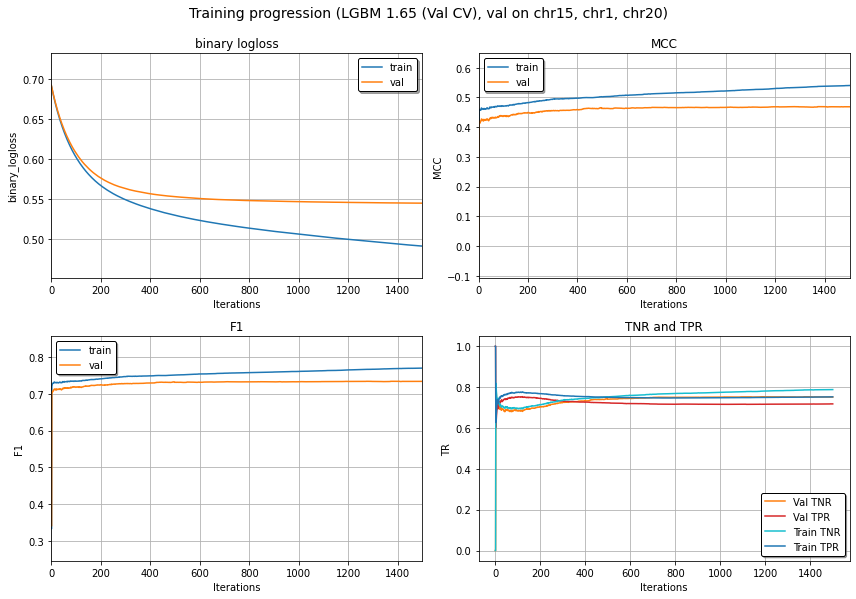

Duration: 0:16:50.312755

> Starting CV iteration 3, valid chrs = chr11, chr22, chrY
[LightGBM] [Info] Number of positive: 45595, number of negative: 44609
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 75560
[LightGBM] [Info] Number of data points in the train set: 90204, number of used features: 1002
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505465 -> initscore=0.021862
[LightGBM] [Info] Start training from score 0.021862


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.636599	train's MCC: 0.455567	train's F1: 0.724597	train's TNR: 0.656616	train's TPR: 0.79432	val's binary_logloss: 0.644587	val's MCC: 0.395505	val's F1: 0.690326	val's TNR: 0.599447	val's TPR: 0.789674
[100]	train's binary_logloss: 0.603794	train's MCC: 0.463111	train's F1: 0.728984	train's TNR: 0.667623	train's TPR: 0.791644	val's binary_logloss: 0.618167	val's MCC: 0.398252	val's F1: 0.692111	val's TNR: 0.603914	val's TPR: 0.788333
[150]	train's binary_logloss: 0.582796	train's MCC: 0.470341	train's F1: 0.733325	train's TNR: 0.680872	train's TPR: 0.786599	val's binary_logloss: 0.602721	val's MCC: 0.407961	val's F1: 0.698375	val's TNR: 0.620081	val's TPR: 0.783192
[200]	train's binary_logloss: 0.568642	train's MCC: 0.478671	train's F1: 0.738246	train's TNR: 0.697258	train's TPR: 0.779603	val's binary_logloss: 0.593812	val's MCC: 0.41201	val's F1: 0.701878	val's TNR: 0.635397	val's TPR: 0.773357
[250]	train's binary_logloss: 0.558608	train's MCC: 0.48482

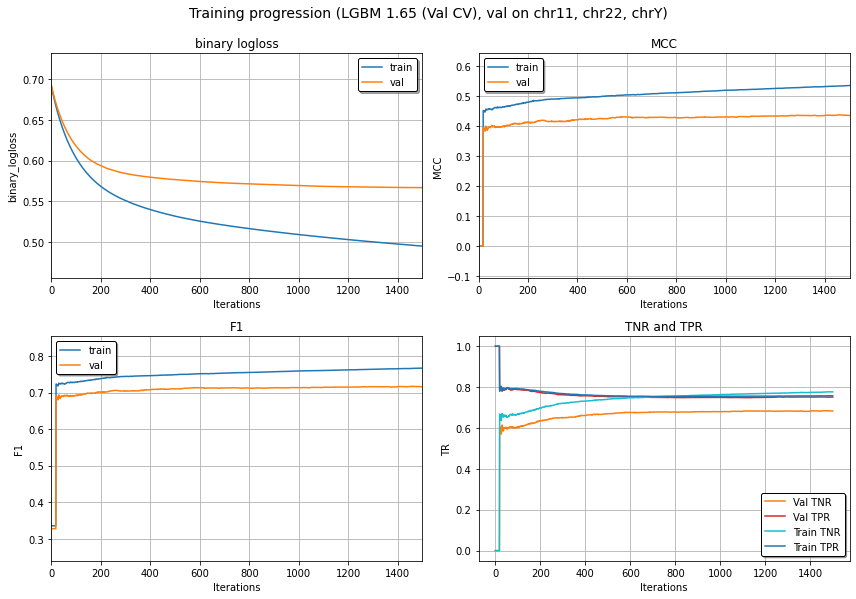

Duration: 0:16:59.557797

> Starting CV iteration 4, valid chrs = chr21, chr5, chr7
[LightGBM] [Info] Number of positive: 43437, number of negative: 42390
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 75186
[LightGBM] [Info] Number of data points in the train set: 85827, number of used features: 1002
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506099 -> initscore=0.024399
[LightGBM] [Info] Start training from score 0.024399


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.637095	train's MCC: 0.449861	train's F1: 0.722149	train's TNR: 0.65782	train's TPR: 0.787923	val's binary_logloss: 0.64189	val's MCC: 0.450004	val's F1: 0.723307	val's TNR: 0.681936	val's TPR: 0.766888
[100]	train's binary_logloss: 0.604767	train's MCC: 0.455709	train's F1: 0.724942	train's TNR: 0.659377	train's TPR: 0.791998	val's binary_logloss: 0.610908	val's MCC: 0.45859	val's F1: 0.727589	val's TNR: 0.686127	val's TPR: 0.771261
[150]	train's binary_logloss: 0.584214	train's MCC: 0.463182	train's F1: 0.729557	train's TNR: 0.674168	train's TPR: 0.785851	val's binary_logloss: 0.590571	val's MCC: 0.471315	val's F1: 0.734574	val's TNR: 0.702601	val's TPR: 0.768094
[200]	train's binary_logloss: 0.570423	train's MCC: 0.470356	train's F1: 0.73391	train's TNR: 0.689455	train's TPR: 0.778806	val's binary_logloss: 0.576541	val's MCC: 0.483828	val's F1: 0.741436	val's TNR: 0.721965	val's TPR: 0.761761
[250]	train's binary_logloss: 0.560652	train's MCC: 0.476191	

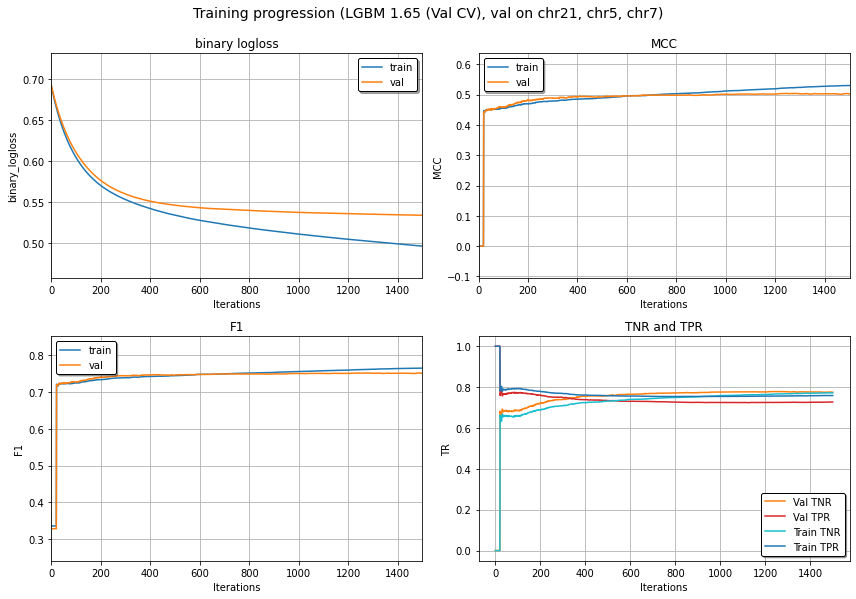

Duration: 0:17:20.330401

> Starting CV iteration 5, valid chrs = chr8, chr18, chr19
[LightGBM] [Info] Number of positive: 43373, number of negative: 42746
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 74080
[LightGBM] [Info] Number of data points in the train set: 86119, number of used features: 1002
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503640 -> initscore=0.014562
[LightGBM] [Info] Start training from score 0.014562


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.636692	train's MCC: 0.461508	train's F1: 0.729196	train's TNR: 0.681584	train's TPR: 0.77765	val's binary_logloss: 0.639614	val's MCC: 0.4262	val's F1: 0.708938	val's TNR: 0.631475	val's TPR: 0.789128
[100]	train's binary_logloss: 0.603998	train's MCC: 0.463492	train's F1: 0.729723	train's TNR: 0.675899	train's TPR: 0.784682	val's binary_logloss: 0.609951	val's MCC: 0.431872	val's F1: 0.710782	val's TNR: 0.625381	val's TPR: 0.799582
[150]	train's binary_logloss: 0.583119	train's MCC: 0.471201	train's F1: 0.734206	train's TNR: 0.689187	train's TPR: 0.779932	val's binary_logloss: 0.592319	val's MCC: 0.440979	val's F1: 0.716326	val's TNR: 0.639244	val's TPR: 0.795998
[200]	train's binary_logloss: 0.569061	train's MCC: 0.475658	train's F1: 0.736729	train's TNR: 0.696533	train's TPR: 0.777442	val's binary_logloss: 0.581266	val's MCC: 0.441584	val's F1: 0.716768	val's TNR: 0.64092	val's TPR: 0.795102
[250]	train's binary_logloss: 0.559096	train's MCC: 0.48143	t

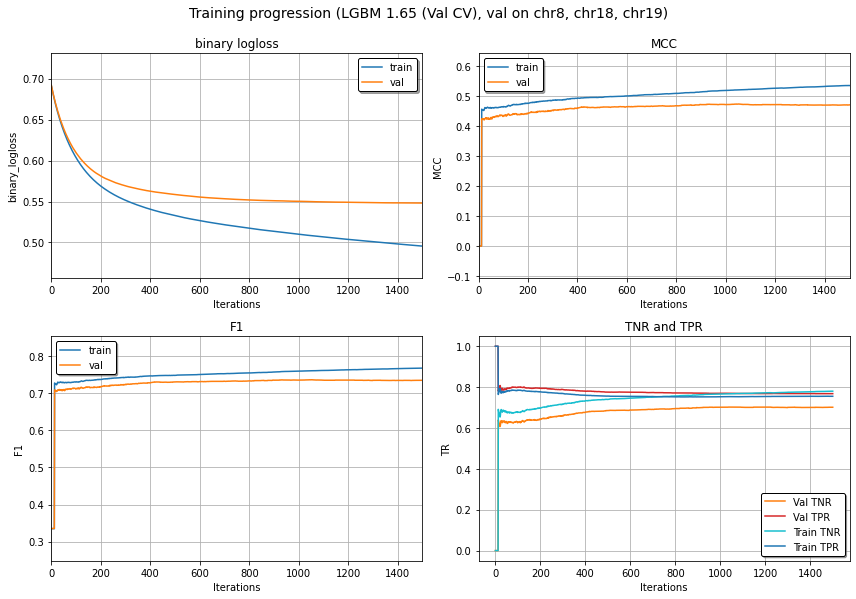

Duration: 0:17:16.870886

> Starting CV iteration 6, valid chrs = chrX, chr6, chr17
[LightGBM] [Info] Number of positive: 41490, number of negative: 41220
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 72824
[LightGBM] [Info] Number of data points in the train set: 82710, number of used features: 1002
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501632 -> initscore=0.006529
[LightGBM] [Info] Start training from score 0.006529


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.636882	train's MCC: 0.459365	train's F1: 0.729057	train's TNR: 0.699102	train's TPR: 0.759388	val's binary_logloss: 0.636914	val's MCC: 0.446489	val's F1: 0.722342	val's TNR: 0.678863	val's TPR: 0.76559
[100]	train's binary_logloss: 0.604501	train's MCC: 0.463396	train's F1: 0.730497	train's TNR: 0.689544	train's TPR: 0.77221	val's binary_logloss: 0.604858	val's MCC: 0.454603	val's F1: 0.725836	val's TNR: 0.673053	val's TPR: 0.778529
[150]	train's binary_logloss: 0.583875	train's MCC: 0.467568	train's F1: 0.732781	train's TNR: 0.695294	train's TPR: 0.770885	val's binary_logloss: 0.585056	val's MCC: 0.460029	val's F1: 0.72872	val's TNR: 0.678739	val's TPR: 0.778529
[200]	train's binary_logloss: 0.570029	train's MCC: 0.472858	train's F1: 0.735699	train's TNR: 0.70359	train's TPR: 0.768233	val's binary_logloss: 0.572194	val's MCC: 0.470694	val's F1: 0.734493	val's TNR: 0.692583	val's TPR: 0.776081
[250]	train's binary_logloss: 0.560164	train's MCC: 0.478069	

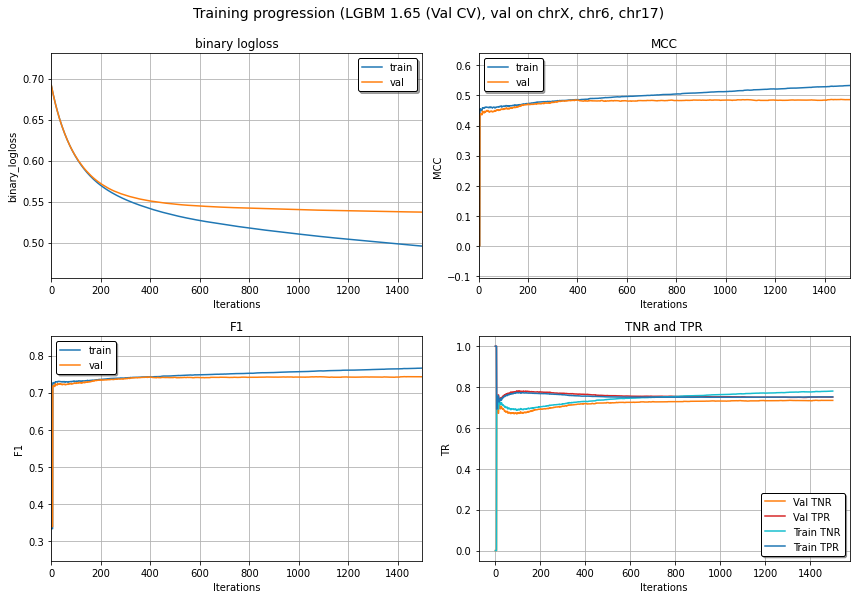

Duration: 0:17:15.553725

> Starting CV iteration 7, valid chrs = chr16, chr14, chr9
[LightGBM] [Info] Number of positive: 43208, number of negative: 42373
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 74342
[LightGBM] [Info] Number of data points in the train set: 85581, number of used features: 1002
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504878 -> initscore=0.019514
[LightGBM] [Info] Start training from score 0.019514


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.637016	train's MCC: 0.457866	train's F1: 0.726757	train's TNR: 0.670215	train's TPR: 0.784438	val's binary_logloss: 0.64002	val's MCC: 0.430539	val's F1: 0.710916	val's TNR: 0.636731	val's TPR: 0.788952
[100]	train's binary_logloss: 0.604548	train's MCC: 0.464636	train's F1: 0.730139	train's TNR: 0.673707	train's TPR: 0.787678	val's binary_logloss: 0.609929	val's MCC: 0.434676	val's F1: 0.713062	val's TNR: 0.639614	val's TPR: 0.790264
[150]	train's binary_logloss: 0.583824	train's MCC: 0.469431	train's F1: 0.733091	train's TNR: 0.683973	train's TPR: 0.782957	val's binary_logloss: 0.591295	val's MCC: 0.444586	val's F1: 0.719048	val's TNR: 0.655182	val's TPR: 0.785746
[200]	train's binary_logloss: 0.569892	train's MCC: 0.474645	train's F1: 0.736194	train's TNR: 0.694806	train's TPR: 0.778027	val's binary_logloss: 0.579293	val's MCC: 0.45331	val's F1: 0.724311	val's TNR: 0.670174	val's TPR: 0.780498
[250]	train's binary_logloss: 0.559973	train's MCC: 0.47835

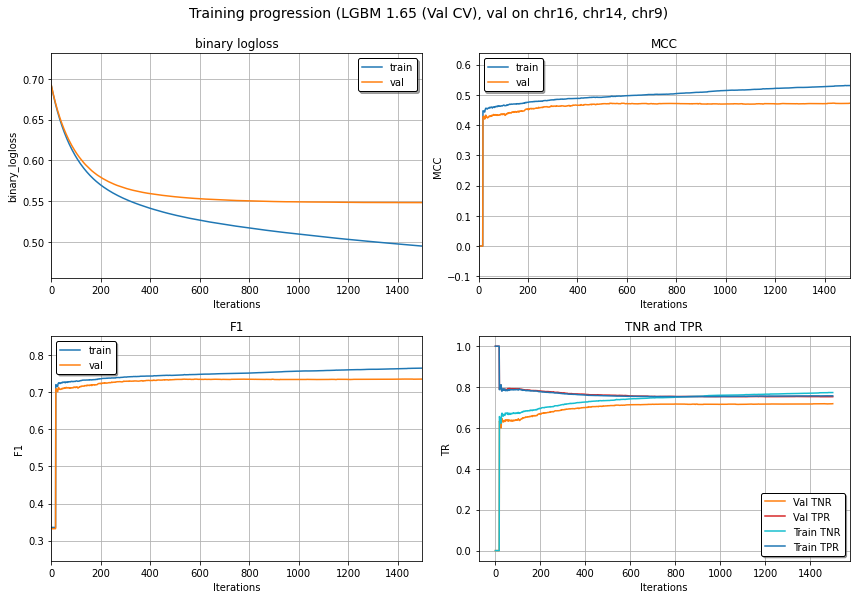

Duration: 0:17:19.951519

>> LGBM 1.65 (Val CV) CV final report
Train accuracy: 0.7666
Train F1-score: 0.7666
Train MCC: 0.5335
Val accuracy: 0.7391
Val F1-score: 0.7391
Val MCC: 0.4782
Val TNR = 74.00%
Val TPR = 74.00%
Duration: 2:00:16.844005


In [ ]:
# LGBM with increased positive weight
params = {"application" : "binary",
          "metric" : "binary_logloss",
          "force_row_wise" : True,
          "learning_rate" : learning_rate,
          "scale_pos_weight": 1.65,
          'device': 'gpu',
          'gpu_platform_id': 0,
          'gpu_device_id': 0         
}
lgb_cv_train_output, lgb_cv_val_output, lgb_importance = lgb_cv(X_TRAIN, y_TRAIN, metadata_train, params, 
                                                         num_iterations=1500, cv_seed=33, plot_eval=True,
                                                         name="LGBM 1.65 (Val CV)")

In [ ]:
# Store prediction
lgb_cv_train_output.to_csv(f"{DIRECTORY}lgb_cv_train_output_{FILENAME}.csv", index=False)
lgb_cv_val_output.to_csv(f"{DIRECTORY}lgb_cv_val_output_{FILENAME}.csv", index=False)

### LGBM prediction on TEST data

In [ ]:
# LGBM prediction on TEST data

def lgb_test_pred(xtrain, ytrain, xtest, ytest, par, 
                  num_iterations=1500, early_stopping_rounds=None,
                  class_weigth=None, plot_eval=False, 
                  normalization=True, name="LGBM"):
  print(f">> {name} train on full TRAIN data and pred on TEST data")
  # Set class weigth
  if class_weigth is not None:
    par = lgb_class_weigths(ytrain, class_weight, par)
  # Print parameters
  lgb_print_par(par, num_iterations, early_stopping_rounds)
  print("")
  # Normalization
  if normalization:
    xtrain, xtest = normalize(xtrain, xtest)
  # Train and predict   
  model, train_yprob, train_ypred, test_yprob, test_ypred = lgb_train_pred(xtrain, ytrain, xtest, ytest, par=params,
                                                                           num_iterations=num_iterations,
                                                                           early_stopping_rounds=early_stopping_rounds,
                                                                           plot_eval=plot_eval, name=name)
  # Store results
  importance = pd.DataFrame()
  importance["feature"] = list(xtrain.columns)
  importance["average"] = model.feature_importance(importance_type='gain')
  train_output = pd.DataFrame({"yprob": train_yprob, "ypred": train_ypred, "ytrue": ytrain})
  test_output = pd.DataFrame({"yprob": test_yprob, "ypred": test_ypred, "ytrue": ytest})
  return model, train_output, test_output, importance

params = {"application" : "binary",
          "metric" : "binary_logloss",
          "force_row_wise" : True,
          "learning_rate" : learning_rate,
          "scale_pos_weight": 1.65,
          'device': 'gpu',
          'gpu_platform_id': 0,
          'gpu_device_id': 0         
}
_, lgb_train_output, lgb_test_output, _ = lgb_test_pred(X_TRAIN, y_TRAIN, X_TEST, y_TEST, par=params,
                                                        num_iterations=1500, plot_eval=False, 
                                                        name="LGBM 1.65 (Test)")

>> LGBM 1.65 (Test) train on full TRAIN data and pred on TEST data

Parameters:
  num_iterations = 1500
  early_stopping_rounds = None
  application = binary
  metric = binary_logloss
  force_row_wise = True
  learning_rate = 0.009
  scale_pos_weight = 1.65
  device = gpu
  gpu_platform_id = 0
  gpu_device_id = 0

[LightGBM] [Info] Number of positive: 50069, number of negative: 49310
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 84607
[LightGBM] [Info] Number of data points in the train set: 99379, number of used features: 1002
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503819 -> initscore=0.015275
[LightGBM] [Info] St

In [ ]:
# Store prediction
lgb_train_output.to_csv(f"{DIRECTORY}lgb_train_output_{FILENAME}.csv", index=False)
lgb_test_output.to_csv(f"{DIRECTORY}lgb_test_output_{FILENAME}.csv", index=False)

## SVM

SVM SVC model

In [ ]:
# SVM SVC
def svm_pred(model, x):
  y_prob = model.predict_proba(x)[:,1]
  y_pred = model.predict(x)
  return y_prob, y_pred

def svm_train_pred(xtrain, ytrain, xval, yval, 
                   gamma="auto", class_weight=None, 
                   train_only=False, cv_iter=None, name="SVM"):
  start_time = datetime.now()
  # Train
  model = SVC(kernel='rbf', C=100, probability=True, gamma=gamma, class_weight=class_weight)
  model.fit(xtrain, ytrain)
  # Predict
  if train_only:
    return model
  else:
    ytrain_prob, ytrain_pred = svm_pred(model, xtrain)
    yval_prob, yval_pred = svm_pred(model, xval)
    # Evaluate
    print_eval(ytrain, ytrain_pred, yval, yval_pred, name)
    # Store CV iteration prediction
    if cv_iter is not None:
      store_cv_iter(ytrain_prob, ytrain_pred, ytrain,
                    yval_prob, yval_pred, yval, cv_iter, model="svm")
    return model, ytrain_prob, ytrain_pred, yval_prob, yval_pred
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")

SVM CV

In [ ]:
# SVM CV
def svm_cv(xtrain, ytrain, metadata, n_val_chr=3, cv_seed=None, 
           svm_algo="svc", gamma="auto", class_weight=None, 
           normalization=True, start_cv_iter=1, name="SVM"):
  start_time = datetime.now()
  print(f"Performing {name} {svm_algo.upper()} CV")
  # Initialize arrays to store predictions, true values
  train_yprob_vec, train_ypred_vec, train_ytrue_vec = np.array([]), np.array([]), np.array([])
  val_yprob_vec, val_ypred_vec, val_ytrue_vec = np.array([]), np.array([]), np.array([])
  # Compute class weights if requested
  if class_weight == "custom":
    class_weight = get_class_weights(ytrain.values)
  print(f"Class weigths = {class_weight}")  
  # CV by chromosomes
  chr_list = np.unique(metadata.chr)
  random.seed(cv_seed)
  random.shuffle(chr_list)
  k = len(chr_list) // n_val_chr
  val_chr_folds = np.array_split(chr_list, k)
  # Start CV iteration
  n = start_cv_iter
  for i, val_chr in enumerate(val_chr_folds[n-1:]):
    print(f"\n> Starting CV iteration {i+n}, valid chrs = {', '.join(str(i) for i in val_chr)}") 
    ival = metadata.chr.isin(val_chr)
    X_train, X_val = xtrain[~ival], xtrain[ival]
    y_train, y_val = ytrain[~ival], ytrain[ival]
    # Normalization
    if normalization:
      X_train, X_val = normalize(X_train, X_val)
    # Train and predict
    [_, train_yprob, train_ypred, 
    val_yprob, val_ypred] = svm_train_pred(X_train, y_train, X_val, y_val, 
                                            class_weight=class_weight, gamma=gamma, cv_iter=i+n)
    # Store prediction on training data
    train_yprob_vec = np.concatenate((train_yprob_vec, train_yprob))
    train_ypred_vec = np.concatenate((train_ypred_vec, train_ypred))
    train_ytrue_vec = np.concatenate((train_ytrue_vec, y_train))
    # Store prediction on validation data
    val_yprob_vec = np.concatenate((val_yprob_vec, val_yprob))
    val_ypred_vec = np.concatenate((val_ypred_vec, val_ypred))
    val_ytrue_vec = np.concatenate((val_ytrue_vec, y_val))
  # Stack training and validation predictions into two panda df
  train_output = pd.DataFrame({"yprob": train_yprob_vec, "ypred": train_ypred_vec, "ytrue": train_ytrue_vec})
  val_output = pd.DataFrame({"yprob": val_yprob_vec, "ypred": val_ypred_vec, "ytrue": val_ytrue_vec})
  # Evaluate
  print(f"\n>> {name} CV final report")
  print_output_eval(train_output, val_output)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return train_output, val_output

In [ ]:
svm_cv_train_output, svm_cv_val_output = svm_cv(X_TRAIN, y_TRAIN, metadata_train, gamma=0.1, cv_seed=33)

In [ ]:
# Store prediction
svm_cv_train_output.to_csv(f"{DIRECTORY}svm_cv_train_output_{FILENAME}.csv", index=False)
svm_cv_val_output.to_csv(f"{DIRECTORY}svm_cv_val_output_{FILENAME}.csv", index=False)

### SVM prediction on TEST data

In [ ]:
# SVM prediction on test data
def svm_test_pred(xtrain, ytrain, xtest, ytest, 
                  gamma="auto", class_weight=None, 
                  normalization=True, train_only=True, name="SVM"):
  start_time = datetime.now()
  print(f">> {name} train on full TRAIN data and pred on TEST data")
  # Compute class weights if requested
  if class_weight == "custom":
    class_weight = get_class_weights(ytrain.values)
  print(f"Class weigths = {class_weight}")  
  # Normalization
  if normalization:
    xtrain, xtest = normalize(xtrain, xtest)
  # Train
  model = svm_train_pred(xtrain, ytrain, xtest, ytest, gamma=gamma,
                         class_weight=class_weight, train_only=True)
  # Predict
  ytrain_prob, ytrain_pred = svm_pred(model, xtrain)
  ytest_prob, ytest_pred = svm_pred(model, xtest)
  train_output = pd.DataFrame({"yprob": ytrain_prob, "ypred": ytrain_pred, "ytrue": ytrain})
  test_output = pd.DataFrame({"yprob": ytest_prob, "ypred": ytest_pred, "ytrue": ytest})
  # # Evaluate
  print_output_eval(train_output, test_output, is_test=True)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return model, train_output, test_output

In [ ]:
_, svm_train_output, svm_test_output = svm_test_pred(X_TRAIN, y_TRAIN, X_TEST, y_TEST,
                                                     gamma=0.1, name="SVM (Test)")

>> SVM (Test) train on full TRAIN data and pred on TEST data
Class weigths = None
Train accuracy: 0.7824
Train F1-score: 0.7779
Train MCC: 0.5932
Test accuracy: 0.7254
Test F1-score: 0.7151
Test MCC: 0.4676
Test TNR = 88.00%
Test TPR = 55.00%
Duration: 3:08:46.991494


In [ ]:
# Store prediction
svm_train_output.to_csv(f"{DIRECTORY}svm_train_output_{FILENAME}.csv", index=False)
svm_test_output.to_csv(f"{DIRECTORY}svm_test_output_{FILENAME}.csv", index=False)

## Features importance

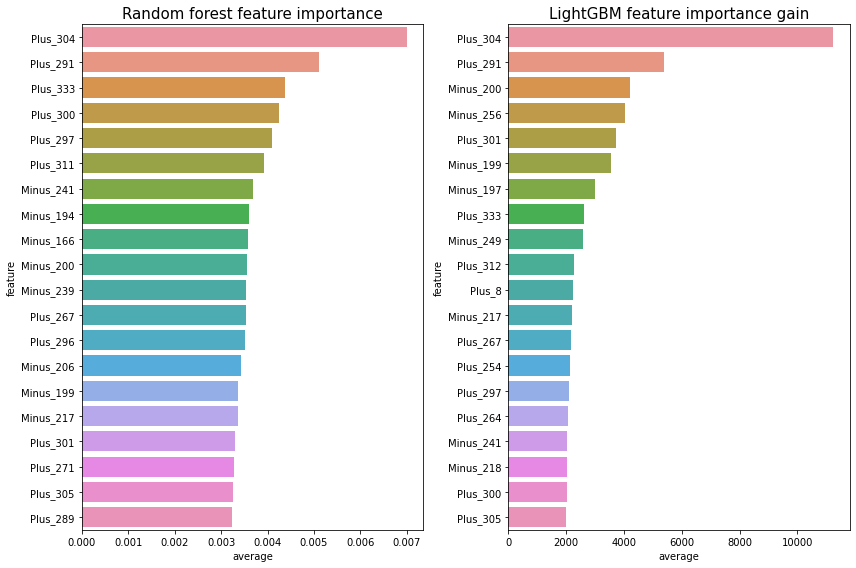

In [ ]:
# Feature importance
plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0, 0])
sns.barplot(x='average', y='feature', data=rf_importance.sort_values('average', ascending=False).iloc[0:20], ax=ax)
plt.title("Random forest feature importance", fontsize=15)

ax = plt.subplot(gs[0, 1])
sns.barplot(x='average', y='feature', data=lgb_importance.sort_values('average', ascending=False).iloc[0:20], ax=ax)
plt.title("LightGBM feature importance gain", fontsize=15)

# ax = plt.subplot(gs[0, 2])
# sns.barplot(x='lgb_importance_split', y='feature', data=imp_df.sort_values('lgb_importance_split', ascending=False).iloc[0:20], ax=ax)
# ax.set_title('LightGBM feature importance split', fontsize=15)
plt.tight_layout()
plt.savefig(f"{DIRECTORY}feature_importance_{FILENAME}.png", dpi = 300)
plt.show()

# Export files
rf_importance.to_csv(f"{DIRECTORY}rf_importance_{FILENAME}.csv", index=False)
lgb_importance.to_csv(f"{DIRECTORY}lgb_importance_{FILENAME}.csv", index=False)

In [ ]:
# # LGBM Feature importance
# plt.rcParams['figure.figsize'] = (18.0, 4)
# fig, ax = plt.subplots(figsize=(12,8))
# lgb.plot_importance(lgb_model, max_num_features=20, height=0.8, ax=ax)
# ax.grid(False)
# plt.title("LightGBM feature importance ", fontsize=15)

## Performance evaluation

In [ ]:
# Load optimal parameters

# RF
rf_cv_train_output = pd.read_csv(f"{DIRECTORY}rf_cv_train_output_{FILENAME}.csv")
rf_cv_val_output = pd.read_csv(f"{DIRECTORY}rf_cv_val_output_{FILENAME}.csv")
rf_train_output = pd.read_csv(f"{DIRECTORY}rf_train_output_{FILENAME}.csv")
rf_test_output = pd.read_csv(f"{DIRECTORY}rf_test_output_{FILENAME}.csv")
# LGBM
lgb_cv_train_output = pd.read_csv(f"{DIRECTORY}lgb_cv_train_output_{FILENAME}.csv")
lgb_cv_val_output = pd.read_csv(f"{DIRECTORY}lgb_cv_val_output_{FILENAME}.csv")
lgb_train_output = pd.read_csv(f"{DIRECTORY}lgb_train_output_{FILENAME}.csv")
lgb_test_output = pd.read_csv(f"{DIRECTORY}lgb_test_output_{FILENAME}.csv")
# SVM
# svm_cv_train_output = pd.read_csv(f"{DIRECTORY}svm_cv_train_output_{FILENAME}.csv")
# svm_cv_val_output = pd.read_csv(f"{DIRECTORY}svm_cv_val_output_{FILENAME}.csv")
svm_cv_train_output, svm_cv_val_output = load_cv_iter("svm", print_shape=True)
svm_train_output = pd.read_csv(f"{DIRECTORY}svm_train_output_{FILENAME}.csv")
svm_test_output = pd.read_csv(f"{DIRECTORY}svm_test_output_{FILENAME}.csv")

CV 1 Train = (85033, 3)
CV 1 Test  = (14346, 3)
CV 2 Train = (80800, 3)
CV 2 Test  = (18579, 3)
CV 3 Train = (90204, 3)
CV 3 Test  = (9175, 3)
CV 4 Train = (85827, 3)
CV 4 Test  = (13552, 3)
CV 5 Train = (86119, 3)
CV 5 Test  = (13260, 3)
CV 6 Train = (82710, 3)
CV 6 Test  = (16669, 3)
CV 7 Train = (85581, 3)
CV 7 Test  = (13798, 3)


In [ ]:
# Initialize the models to evaluate
train_output_lst = rf_cv_train_output, rf_train_output, lgb_cv_train_output, lgb_train_output, svm_cv_train_output, svm_train_output    
test_output_lst = rf_cv_val_output, rf_test_output, lgb_cv_val_output, lgb_test_output, svm_cv_val_output, svm_test_output
names = "RF (Val CV)", "RF (Test)", "LGBM (Val CV)", "LGBM (Test)", "SVM (Val CV)", "SVM (Test)"          

for i, name in enumerate(names):
  print(f"{name} Train = {train_output_lst[i].shape}")
  print(f"{name} Test  = {test_output_lst[i].shape}")

RF (Val CV) Train = (596274, 3)
RF (Val CV) Test  = (99379, 3)
RF (Test) Train = (99379, 3)
RF (Test) Test  = (21665, 3)
LGBM (Val CV) Train = (596274, 3)
LGBM (Val CV) Test  = (99379, 3)
LGBM (Test) Train = (99379, 3)
LGBM (Test) Test  = (21665, 3)
SVM (Val CV) Train = (596274, 3)
SVM (Val CV) Test  = (99379, 3)
SVM (Test) Train = (99379, 3)
SVM (Test) Test  = (21665, 3)


#### Classification report

In [ ]:
# Classification report
for i in range(len(names)):
  print(f"{names[i]}:\n", classification_report(test_output_lst[i]["ytrue"], test_output_lst[i]["ypred"])) 

RF (Val CV):
               precision    recall  f1-score   support

         0.0       0.72      0.74      0.73     49310
         1.0       0.74      0.72      0.73     50069

    accuracy                           0.73     99379
   macro avg       0.73      0.73      0.73     99379
weighted avg       0.73      0.73      0.73     99379

RF (Test):
               precision    recall  f1-score   support

           0       0.73      0.79      0.76     11212
           1       0.75      0.68      0.71     10453

    accuracy                           0.74     21665
   macro avg       0.74      0.73      0.73     21665
weighted avg       0.74      0.74      0.74     21665

LGBM (Val CV):
               precision    recall  f1-score   support

         0.0       0.74      0.74      0.74     49310
         1.0       0.74      0.74      0.74     50069

    accuracy                           0.74     99379
   macro avg       0.74      0.74      0.74     99379
weighted avg       0.74      0.7

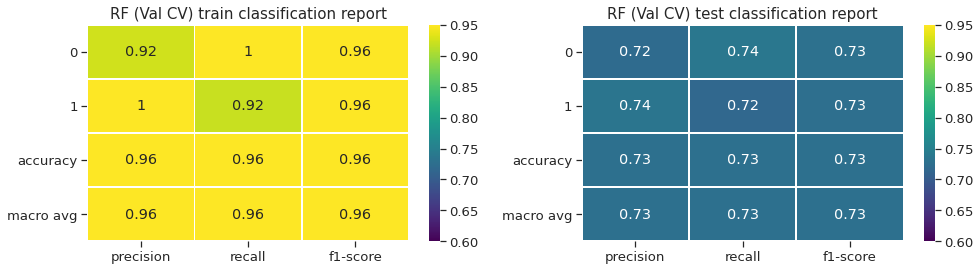

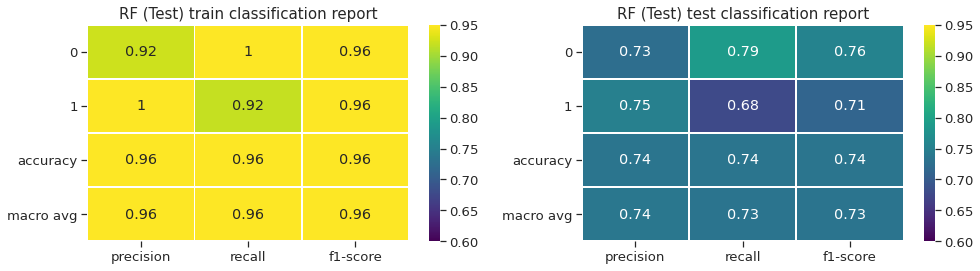

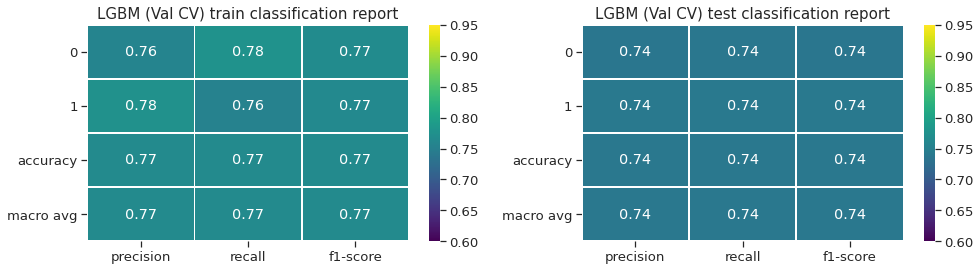

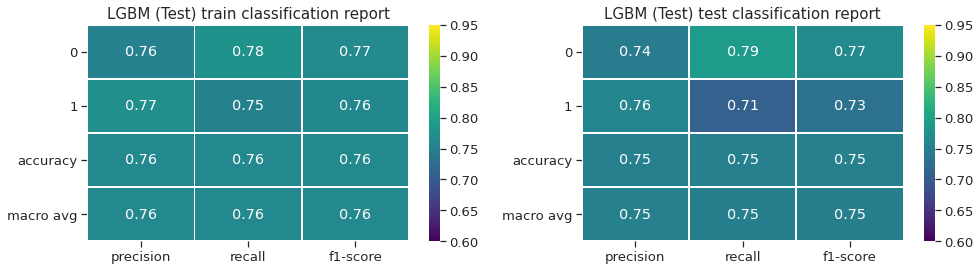

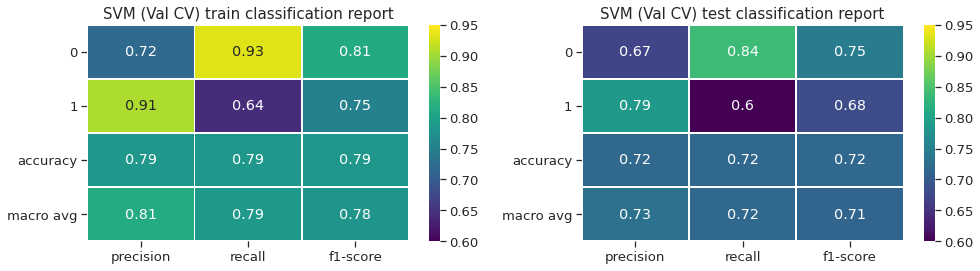

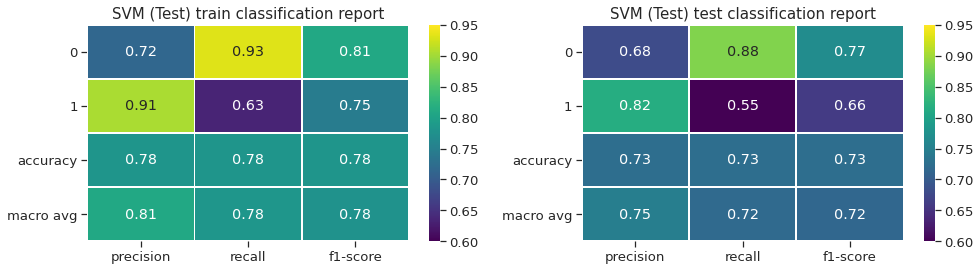

In [ ]:
# Plot classification report
def plot_clf_report(train_output, test_output, name="", save=False):
  plt.figure(figsize=(14, 4))
  gs = gridspec.GridSpec(1, 2)
  sns.set(font_scale=1.2, style="ticks")
  # Train
  ax = plt.subplot(gs[0, 0])
  clf_report = classification_report(train_output["ytrue"], train_output["ypred"],
                                    labels=[0,1], output_dict=True)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].drop(["weighted avg"], axis=1).T, 
              annot=True, linewidths=1, cmap="viridis", ax=ax, vmin=0.6, vmax=0.95)
  ax.set_title(f"{name} train classification report", fontsize=15)
  # Test/Validation
  ax = plt.subplot(gs[0, 1])
  clf_report = classification_report(test_output["ytrue"], test_output["ypred"],
                                    labels=[0,1], output_dict=True)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].drop(["weighted avg"], axis=1).T, 
              annot=True, linewidths=1, cmap="viridis", ax=ax, vmin=0.6, vmax=0.95)
  ax.set_title(f"{name} test classification report", fontsize=15)
  # Layout and save
  plt.tight_layout()
  if save:
    plt.savefig(f"{DIRECTORY}classification_report_{FILENAME}_{name}.png", dpi = 300)
  plt.show()

for i in range(len(names)):
  plot_clf_report(train_output_lst[i], test_output_lst[i], names[i], save=True)

#### Plot some metrics

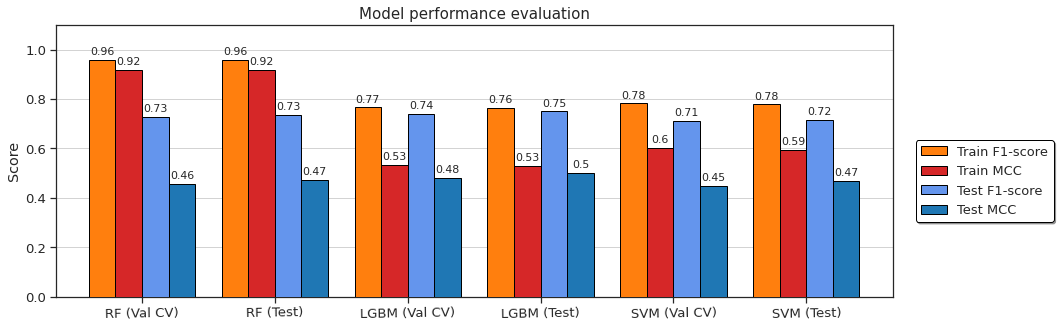

In [ ]:
# Plot accuracy, F1, MCC

def evaluate(ml_output):
  acc = get_accuracy(ml_output["ypred"], ml_output["ytrue"])
  f1 = f1_score(ml_output["ytrue"], ml_output["ypred"], average='macro')
  mcc = matthews_corrcoef(ml_output["ytrue"], ml_output["ypred"])
  return acc, f1, mcc

def evaluate_lst(ml_output_lst):
  lst_acc, lst_f1, lst_mcc = [], [], []
  for ml_output in ml_output_lst: 
    acc, f1, mcc = evaluate(ml_output)
    lst_acc.append(acc)
    lst_f1.append(f1)
    lst_mcc.append(mcc)
  return lst_acc, lst_f1, lst_mcc

def plot_metrics(train_output_lst, test_output_lst, names, 
                 bbox_to_anchor=(1.03, 0.6), annotation_size=13, 
                 save=False, is_test=False):
  # Group by metrics
  train_acc, train_f1, train_mcc = evaluate_lst(train_output_lst)
  test_acc, test_f1, test_mcc = evaluate_lst(test_output_lst)
  # Plot
  # metric_df = pd.DataFrame({"Train Acc": train_acc, "Train F1-score": train_f1, "Train MCC": train_mcc,
  #                           "Test Acc": test_acc, "Test F1-score": test_f1, "Test MCC": test_mcc, }, 
  #                           index = names)
  # ax = metric_df.plot(y=["Train Acc", "Train F1-score", "Train MCC", "Test Acc", "Test F1-score", "Test MCC"], 
  #                     ylim=(0,1.1), figsize=(15,5), kind="bar", zorder=3, ec ="black",
  #                     rot=1, width=0.8, color = ["gold", "tab:orange", "tab:red",
  #                                               "tab:cyan", "cornflowerblue", "tab:blue"])
  metric_df = pd.DataFrame({"Train F1-score": train_f1, "Train MCC": train_mcc,
                            "Test F1-score": test_f1, "Test MCC": test_mcc, }, 
                            index = names)
  ax = metric_df.plot(y=["Train F1-score", "Train MCC","Test F1-score", "Test MCC"], 
                      ylim=(0,1.1), figsize=(15,5), kind="bar", zorder=3, ec ="black",
                      rot=1, width=0.8, color = ["tab:orange", "tab:red",
                                                 "cornflowerblue", "tab:blue"])
  # Add details
  plt.title("Model performance evaluation", fontsize = 15)
  plt.ylabel("Score")
  plt.grid(axis="y", zorder=0, color="lightgray")  
  legend = plt.legend(frameon = 1, shadow = True, bbox_to_anchor=bbox_to_anchor, fontsize=13)
  frame = legend.get_frame()
  frame.set_facecolor('white')
  frame.set_edgecolor('black')
  # Annotate scores on top of the bars
  for p in ax.patches:
    height = p.get_height()
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    xpos='center'
    offset = {'center': 0, 'right': 1, 'left': -1}
    ax.annotate(f"{height:.2}",
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(offset[xpos]*3, 3),  
                textcoords="offset points",  
                ha=ha[xpos], va='bottom', size=annotation_size)
  if save:
    plt.savefig(f"{DIRECTORY}models_performance_{FILENAME}.png", 
                dpi = 300, bbox_extra_artists=(legend,), bbox_inches='tight')
  plt.show()

plot_metrics(train_output_lst, test_output_lst, names, 
             bbox_to_anchor=(1.2, 0.6), annotation_size=11, save=True)                         

#### ROC

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


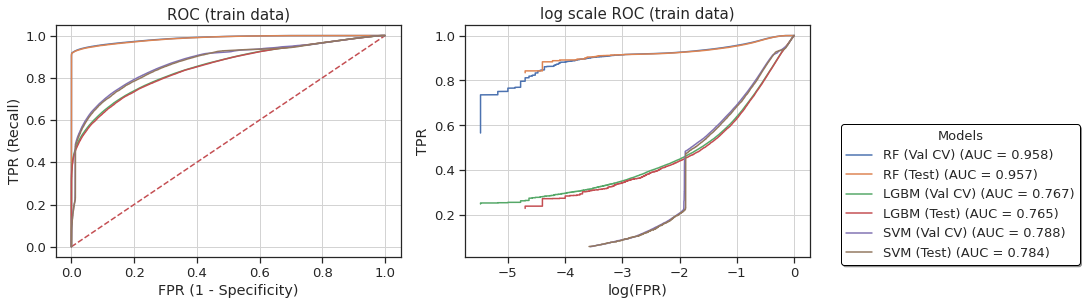

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


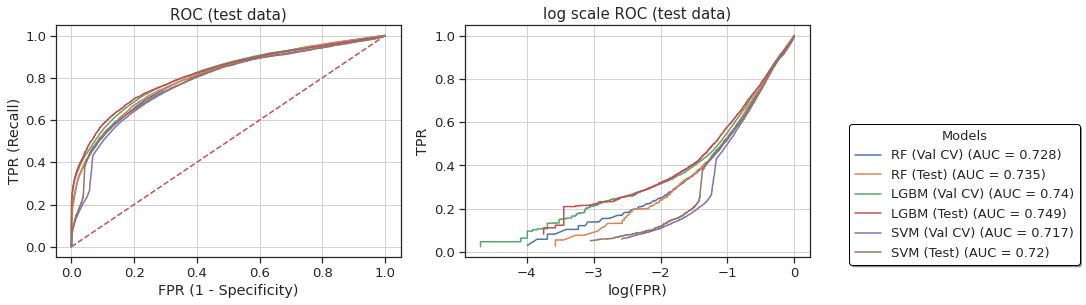

In [ ]:
# Compute AUC, FPR and TPR
def get_auc_fpr_tpr(ml_output):
  auc = roc_auc_score(ml_output["ytrue"], ml_output["ypred"])
  fpr, tpr, _ = roc_curve(ml_output["ytrue"], ml_output["yprob"])
  return auc, fpr, tpr

# Plot ROC
def plot_ROC(output_lst, names, plot_name="", save=False):
  fig, axes = plt.subplots(1, 2, figsize = (16, 4.5))
  # ROC
  for i, output in enumerate(output_lst):
    auc, fpr, tpr = get_auc_fpr_tpr(output)
    axes[0].plot(fpr, tpr, label=f"{names[i]} (AUC = {auc:.3})", zorder=3)
  axes[0].plot([0, 1], [0, 1],'r--')
  axes[0].set_title(f"ROC {plot_name}", fontsize=15)
  axes[0].set_xlabel('FPR (1 - Specificity)')
  axes[0].set_ylabel('TPR (Recall)')
  axes[0].grid(zorder=0, color="lightgray")
  # Log ROC
  for i, output in enumerate(output_lst):
    auc, fpr, tpr = get_auc_fpr_tpr(output)
    axes[1].plot(np.log10(fpr), tpr, label=f"{names[i]} (AUC = {auc:.3})", zorder=3)
  axes[1].set_title(f"log scale ROC {plot_name}", fontsize=15)
  axes[1].set_xlabel('log(FPR)')
  axes[1].set_ylabel('TPR')
  axes[1].grid(zorder=0, color="lightgray")
  # Details
  legend = plt.legend(title="Models", fontsize=13, title_fontsize=13,
                      frameon = 1, shadow = True, bbox_to_anchor=(1.8, 0.6))
  frame = legend.get_frame()
  frame.set_facecolor('white')
  frame.set_edgecolor('black')
  fig.tight_layout()
  fig.subplots_adjust(top=0.89)
  if save:
    plt.savefig(f"{DIRECTORY}ROC_logROC_{plot_name}_{FILENAME}.png", dpi = 300)
  plt.show()

plot_ROC(train_output_lst, names, plot_name="(train data)", save=True)
plot_ROC(test_output_lst, names, plot_name="(test data)", save=True)

#### Precision recall curve

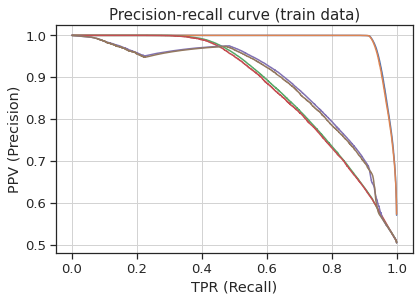

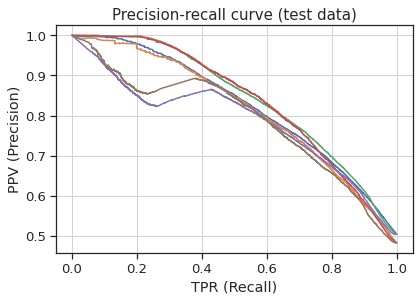

In [ ]:
# Precision-recall curve
def plot_precision_recall_curve(output_lst, names, plot_name="", save=False):
  # Plot the curves
  plt.figure(figsize=(6.4, 4.2))
  # random_clf = len(output_lst[0]["ytrue"][output_lst[0]["ytrue"]==1]) / len(output_lst[0]["ytrue"])
  # plt.plot([0, 1], [random_clf, random_clf], 'r--', zorder=3)
  for i, test_output in enumerate(output_lst):
    precision, recall, thresholds = precision_recall_curve(test_output["ytrue"], test_output["yprob"])
    plt.plot(recall, precision, label=names[i], zorder=3)
  # Add details
  plt.grid(zorder=0, color="lightgray")
  plt.xlabel("TPR (Recall)")
  plt.ylabel("PPV (Precision)")
  plt.title(f"Precision-recall curve {plot_name}", fontsize=15)
  # legend = plt.legend(title="Models", fontsize=13, title_fontsize=13, loc = "lower left",
  #           frameon = 1, shadow = True)
  # frame = legend.get_frame()
  # frame.set_facecolor("white")
  # frame.set_edgecolor("black")
  if save:
    plt.savefig(f"{DIRECTORY}precision-recall_curve_{plot_name}_{FILENAME}.png", dpi = 300)
  plt.show()

plot_precision_recall_curve(train_output_lst, names, plot_name="(train data)", save=True)
plot_precision_recall_curve(test_output_lst, names, plot_name="(test data)", save=True)

#### Confusion matrix

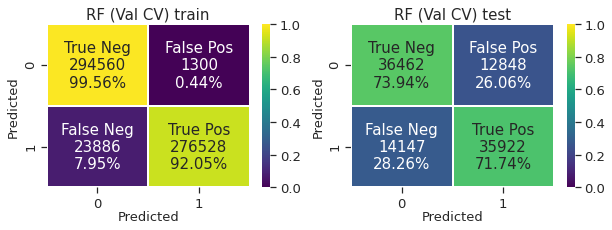

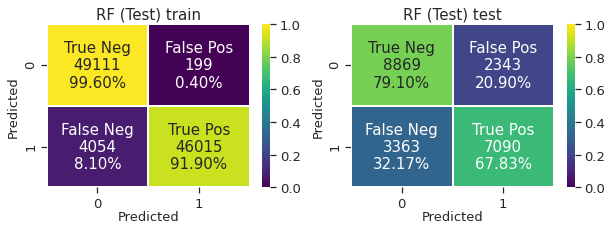

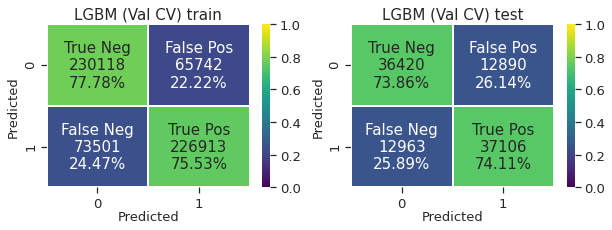

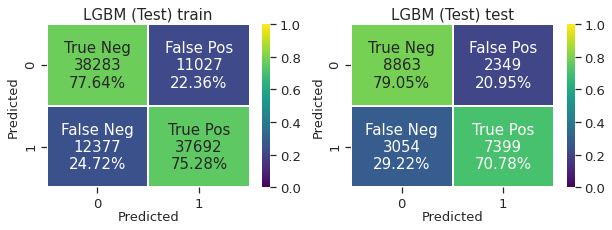

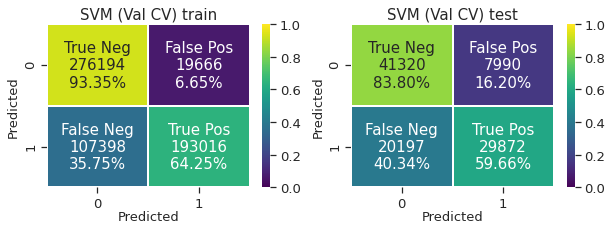

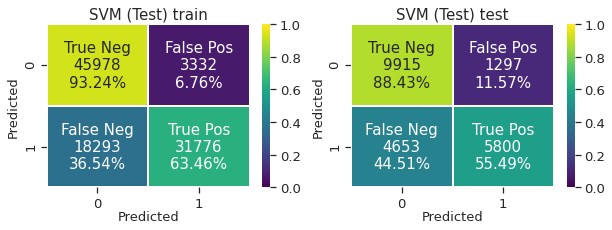

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(train_output, test_output, name="",
                          vmax=0.6, save=False, filename="", cmap='viridis'):
  # Initialize
  test_train_output = train_output, test_output
  plot_names = "train", "test"
  plt.figure(figsize=(10, 3))
  gs = gridspec.GridSpec(1, 2)
  sns.set(font_scale=1.2, style="ticks")
  # Plot train and test/validation 
  for i, output in enumerate(test_train_output):
    ax = plt.subplot(gs[0, i])
    # Get confusion matrix and labels
    cf_matrix = confusion_matrix(output["ytrue"], output["ypred"])
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = [f"{value}" for value in cf_matrix.flatten()]
    row_sums = cf_matrix.sum(axis=1)
    norm_matrix = cf_matrix / row_sums[:, np.newaxis]
    group_percentages = [f"{value*100:.2f}%" for value in norm_matrix.flatten()]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    # Plot heatmap
    sns.heatmap(norm_matrix, annot=labels, annot_kws={"size": 15}, 
                fmt="", vmin=0, vmax=1, cmap=cmap, linewidths=1, ax=ax)
    plt.ylabel("Predicted", fontsize = 13)
    plt.xlabel("Predicted", fontsize = 13, labelpad = -0)
    plt.title(f"{name} {plot_names[i]}", fontsize = 15)
  if save:
    plt.savefig(f"{DIRECTORY}confusion_matrix_{name}_{FILENAME}.png", 
                dpi = 300)
  plt.show()

for i in range(len(names)):
  plot_confusion_matrix(train_output_lst[i], test_output_lst[i], names[i], save=True)

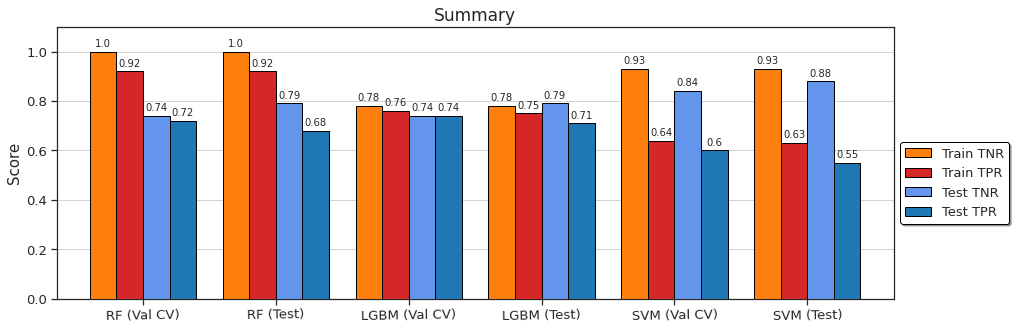

In [ ]:
# Barplot of TNR and TPR

def get_tnr_tpr_lst(ml_output_lst):
  lst_tnr, lst_tpr = [], []
  for ml_output in ml_output_lst: 
    tnr, tpr = get_tnr_tpr(ml_output["ytrue"], ml_output["ypred"])
    lst_tnr.append(tnr)
    lst_tpr.append(tpr)
  return lst_tnr, lst_tpr
  
def plot_tp_tn(train_output_lst, test_output_lst, names, 
               bbox_to_anchor=(1.03, 0.6), annotation_size=13, 
               save=False):
  # Group by metrics
  train_tnr, train_tpr = get_tnr_tpr_lst(train_output_lst)
  test_tnr, test_tpr = get_tnr_tpr_lst(test_output_lst)
  # Plot
  metric_df = pd.DataFrame({"Train TNR": train_tnr, "Train TPR": train_tpr, 
                            "Test TNR": test_tnr, "Test TPR": test_tpr}, index = names)
  ax = metric_df.plot(y=["Train TNR", "Train TPR", "Test TNR", "Test TPR"], 
                      ylim=(0,1.1), figsize=(15,5), kind="bar", zorder=3, ec ="black",
                      rot=1, width=0.8, color = ["tab:orange", "tab:red", "cornflowerblue", "tab:blue"])
  # Add details
  plt.title("Summary", fontsize = 17)
  plt.ylabel("Score", fontsize = 15)
  plt.grid(axis="y", zorder=0, color="lightgray")  
  legend = plt.legend(frameon = 1, shadow = True, bbox_to_anchor=bbox_to_anchor, fontsize=13)
  frame = legend.get_frame()
  frame.set_facecolor('white')
  frame.set_edgecolor('black')
  # Annotate scores on top of the bars
  for p in ax.patches:
    height = p.get_height()
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    xpos='center'
    offset = {'center': 0, 'right': 1, 'left': -1}
    ax.annotate(f"{height:.2}",
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(offset[xpos]*3, 3),  
                textcoords="offset points",  
                ha=ha[xpos], va='bottom', size=annotation_size)
  if save:
    plt.savefig(f"{DIRECTORY}tnr_tpr_barplot2_{FILENAME}.png", 
                dpi = 300, bbox_extra_artists=(legend,), bbox_inches='tight')
  plt.show()

plot_tp_tn(train_output_lst, test_output_lst, names, bbox_to_anchor=(1, 0.6), annotation_size=10, save=True)    